<a href="https://colab.research.google.com/github/Prabhat1808/Multimodal-IR-Ablation/blob/main/CFSA/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN(Wasserstein Generative Adversarial Network)

WGAN is an extension to the generative adversarial network that both improves the stability when training the model and provides a loss function that correlates with the quality of generated images. Moreover, it seeks an alternate way of training the generator model to better approximate the distribution of data observed in a given training dataset.

Instead of using a discriminator to classify or predict the probability of generated images as being real or fake, the WGAN changes or replaces the discriminator model with a critic that scores the realness or fakeness of a given image.

This change is motivated by a mathematical argument that training the generator should seek a minimization of the distance between the distribution of the data observed in the training dataset and the distribution observed in generated examples. The argument contrasts different distribution distance measures, such as Kullback-Leibler (KL) divergence, Jensen-Shannon (JS) divergence, and the Earth-Mover (EM) distance, referred to as Wasserstein distance.

The benefit of the WGAN is that the training process is more stable and less sensitive to model architecture and choice of hyperparameter configurations. Perhaps most importantly, the loss of the discriminator appears to relate to the quality of images created by the generator.







### WGAN Algorithm
<img scr='./readme_images/wgan-algorithm.png' />

The differences in implementation for the WGAN are as follows:

 1. Use a linear activation function in the output layer of the critic model (instead of sigmoid).
 2. Use -1 labels for real images and 1 labels for fake images (instead of 1 and 0).
 3. Use Wasserstein loss to train the critic and generator models.
 4. Constrain critic model weights to a limited range after each mini batch update (e.g. [-0.01,0.01]).
 5. Update the critic model more times than the generator each iteration (e.g. 5).
 6. Use the RMSProp version of gradient descent with a small learning rate and no momentum (e.g. 0.00005).

# Not working


Reference:
https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

In [ ]:
%matplotlib inline
from numpy import expand_dims, mean, ones

from numpy.random import randn, randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
!mkdir ./images

In [ ]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)


In [ ]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization()) #kernel_constraint=const
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization()) #kernel_constraint=const
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1)) #kernel_constraint=const
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model
 
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	critic.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model
 
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 3
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
      # define subplot
      plt.subplot(10, 10, 1 + i)
      # turn off axis
      plt.axis('off')
      # plot raw pixel data
      plt.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    
    img = mpimg.imread('/content/generated_plot_%04d.png' % (step+1))
    imgplot = plt.imshow(img)
    plt.show()
    # save the generator model
  # 	filename2 = 'model_%04d.h5' % (step+1)
  # 	g_model.save(filename2)
  # 	print('>Saved: %s and %s' % (filename1, filename2))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()
 

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
    
    
#     if (i+1) % 10 == 0: 
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
      
      
		# evaluate the model performance every 'epoch'
		if (i+1) % 50 == 0: # %bat_per_epo
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)
 


11493376/11490434 [==============================] - 0s 0us/step
(6131, 28, 28, 1)
>1, c1=-1.650, c2=-0.015 g=0.001
>2, c1=-5.941, c2=0.062 g=-0.008
>3, c1=-8.860, c2=0.146 g=-0.018
>4, c1=-11.261, c2=0.195 g=-0.025
>5, c1=-13.649, c2=0.248 g=-0.034
>6, c1=-15.000, c2=0.265 g=-0.041
>7, c1=-16.845, c2=0.278 g=-0.051
>8, c1=-18.392, c2=0.294 g=-0.061
>9, c1=-19.474, c2=0.305 g=-0.069
>10, c1=-20.518, c2=0.342 g=-0.079
>11, c1=-21.976, c2=0.385 g=-0.092
>12, c1=-23.271, c2=0.411 g=-0.103
>13, c1=-24.422, c2=0.476 g=-0.117
>14, c1=-24.903, c2=0.547 g=-0.131
>15, c1=-26.023, c2=0.617 g=-0.152
>16, c1=-26.599, c2=0.684 g=-0.174
>17, c1=-27.014, c2=0.877 g=-0.207
>18, c1=-27.860, c2=1.021 g=-0.224
>19, c1=-28.888, c2=1.091 g=-0.249
>20, c1=-29.058, c2=1.079 g=-0.257
>21, c1=-30.399, c2=1.255 g=-0.293
>22, c1=-30.931, c2=1.452 g=-0.336
>23, c1=-30.970, c2=1.824 g=-0.386
>24, c1=-32.037, c2=2.175 g=-0.440
>25, c1=-32.302, c2=2.534 g=-0.505
>26, c1=-33.063, c2=2.826 g=-0.572
>27, c1=-32.764, c2

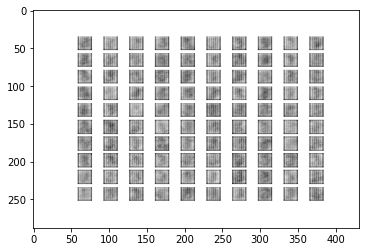

>51, c1=-42.731, c2=-24.224 g=-11.482
>52, c1=-43.185, c2=-25.881 g=-12.890
>53, c1=-44.253, c2=-27.842 g=-14.231
>54, c1=-44.514, c2=-29.224 g=-15.787
>55, c1=-45.367, c2=-30.613 g=-17.763
>56, c1=-46.399, c2=-31.793 g=-19.814
>57, c1=-46.799, c2=-33.146 g=-22.198
>58, c1=-47.094, c2=-34.061 g=-24.548
>59, c1=-48.001, c2=-35.035 g=-27.678
>60, c1=-49.252, c2=-35.743 g=-30.019
>61, c1=-48.710, c2=-36.304 g=-33.145
>62, c1=-50.516, c2=-37.251 g=-35.244
>63, c1=-50.799, c2=-38.130 g=-38.213
>64, c1=-50.975, c2=-38.963 g=-41.738
>65, c1=-52.545, c2=-39.427 g=-46.394
>66, c1=-51.896, c2=-39.758 g=-50.172
>67, c1=-52.822, c2=-40.381 g=-57.082
>68, c1=-52.962, c2=-40.464 g=-60.797
>69, c1=-53.099, c2=-40.699 g=-63.945
>70, c1=-54.503, c2=-41.767 g=-67.873
>71, c1=-54.388, c2=-42.905 g=-69.551
>72, c1=-55.612, c2=-43.485 g=-74.864
>73, c1=-56.427, c2=-44.761 g=-81.490
>74, c1=-57.078, c2=-45.774 g=-84.348
>75, c1=-57.482, c2=-46.556 g=-89.149
>76, c1=-58.748, c2=-47.521 g=-89.038
>77, c1=-58.

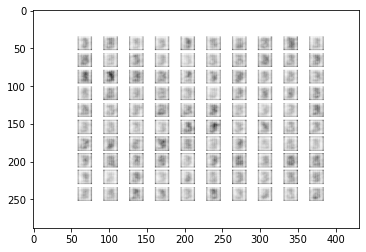

>101, c1=-77.348, c2=-68.894 g=-144.477
>102, c1=-77.678, c2=-69.585 g=-144.680
>103, c1=-77.883, c2=-70.204 g=-135.677
>104, c1=-79.355, c2=-70.917 g=-155.803
>105, c1=-79.982, c2=-71.849 g=-145.280
>106, c1=-80.280, c2=-72.439 g=-144.065
>107, c1=-81.671, c2=-73.274 g=-143.505
>108, c1=-81.990, c2=-73.802 g=-153.107
>109, c1=-83.195, c2=-74.677 g=-158.153
>110, c1=-83.248, c2=-75.350 g=-158.023
>111, c1=-85.164, c2=-76.051 g=-158.908
>112, c1=-85.309, c2=-76.744 g=-157.647
>113, c1=-85.562, c2=-77.350 g=-151.434
>114, c1=-86.649, c2=-78.149 g=-155.725
>115, c1=-87.091, c2=-78.665 g=-160.681
>116, c1=-88.746, c2=-79.345 g=-168.142
>117, c1=-89.258, c2=-80.213 g=-173.806
>118, c1=-89.233, c2=-80.882 g=-163.048
>119, c1=-89.970, c2=-81.637 g=-154.304
>120, c1=-90.927, c2=-82.193 g=-166.217
>121, c1=-91.674, c2=-82.929 g=-165.873
>122, c1=-92.308, c2=-83.593 g=-166.175
>123, c1=-93.519, c2=-84.308 g=-164.392
>124, c1=-93.494, c2=-84.904 g=-180.834
>125, c1=-93.927, c2=-85.639 g=-168.569


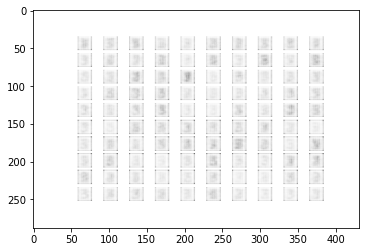

>151, c1=-113.985, c2=-103.739 g=-195.835
>152, c1=-115.859, c2=-104.403 g=-200.754
>153, c1=-116.149, c2=-105.115 g=-198.983
>154, c1=-116.453, c2=-105.904 g=-199.172
>155, c1=-117.688, c2=-106.643 g=-215.306
>156, c1=-118.701, c2=-107.385 g=-201.061
>157, c1=-119.808, c2=-108.088 g=-220.595
>158, c1=-120.023, c2=-108.866 g=-205.730
>159, c1=-121.635, c2=-109.575 g=-214.824
>160, c1=-121.281, c2=-110.309 g=-190.846
>161, c1=-122.571, c2=-111.050 g=-213.141
>162, c1=-122.951, c2=-111.784 g=-211.294
>163, c1=-124.392, c2=-112.586 g=-215.580
>164, c1=-124.682, c2=-113.323 g=-205.841
>165, c1=-125.148, c2=-114.031 g=-226.304
>166, c1=-126.344, c2=-114.770 g=-223.501
>167, c1=-127.577, c2=-115.468 g=-217.611
>168, c1=-128.140, c2=-116.275 g=-245.743
>169, c1=-129.183, c2=-117.048 g=-226.585
>170, c1=-129.199, c2=-117.826 g=-238.465
>171, c1=-130.457, c2=-118.584 g=-233.259
>172, c1=-131.638, c2=-119.374 g=-249.266
>173, c1=-132.244, c2=-120.118 g=-227.450
>174, c1=-133.046, c2=-120.909 g=-

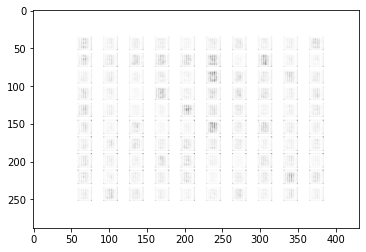

>201, c1=-154.370, c2=-142.326 g=-269.385
>202, c1=-155.834, c2=-143.128 g=-285.328
>203, c1=-156.585, c2=-143.936 g=-272.935
>204, c1=-157.276, c2=-144.734 g=-277.883
>205, c1=-158.926, c2=-145.587 g=-286.493
>206, c1=-158.180, c2=-146.348 g=-282.948
>207, c1=-159.480, c2=-147.191 g=-299.768
>208, c1=-160.914, c2=-147.972 g=-302.530
>209, c1=-161.230, c2=-148.788 g=-294.841
>210, c1=-162.852, c2=-149.591 g=-291.770
>211, c1=-164.754, c2=-150.483 g=-313.901
>212, c1=-164.268, c2=-151.286 g=-301.351
>213, c1=-165.862, c2=-152.139 g=-304.589
>214, c1=-165.933, c2=-152.967 g=-327.892
>215, c1=-167.536, c2=-153.797 g=-303.065
>216, c1=-168.192, c2=-154.632 g=-286.565
>217, c1=-168.820, c2=-155.402 g=-293.273
>218, c1=-169.862, c2=-156.233 g=-278.545
>219, c1=-170.064, c2=-157.034 g=-327.307
>220, c1=-170.932, c2=-157.865 g=-297.377
>221, c1=-172.680, c2=-158.729 g=-313.957
>222, c1=-173.213, c2=-159.599 g=-297.705
>223, c1=-173.605, c2=-160.381 g=-299.403
>224, c1=-175.071, c2=-161.244 g=-

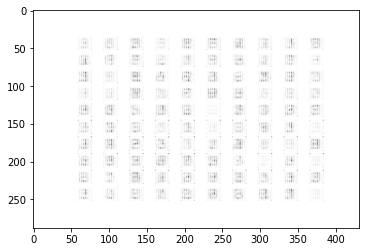

>251, c1=-199.124, c2=-184.254 g=-362.206
>252, c1=-199.233, c2=-185.135 g=-348.873
>253, c1=-200.939, c2=-186.012 g=-356.883
>254, c1=-202.217, c2=-186.904 g=-367.916
>255, c1=-202.787, c2=-187.743 g=-344.722
>256, c1=-202.832, c2=-188.676 g=-356.237
>257, c1=-204.413, c2=-189.569 g=-397.832
>258, c1=-204.539, c2=-190.416 g=-355.086
>259, c1=-205.845, c2=-191.327 g=-375.261
>260, c1=-205.971, c2=-192.181 g=-382.809
>261, c1=-208.180, c2=-193.095 g=-391.238
>262, c1=-208.825, c2=-193.981 g=-387.100
>263, c1=-209.806, c2=-194.834 g=-363.401
>264, c1=-210.318, c2=-195.731 g=-385.402
>265, c1=-211.588, c2=-196.609 g=-397.740
>266, c1=-213.055, c2=-197.512 g=-404.971
>267, c1=-212.774, c2=-198.391 g=-386.324
>268, c1=-214.089, c2=-199.270 g=-402.186
>269, c1=-213.808, c2=-200.160 g=-402.946
>270, c1=-215.706, c2=-201.068 g=-408.552
>271, c1=-217.448, c2=-201.997 g=-391.318
>272, c1=-217.428, c2=-202.818 g=-401.245
>273, c1=-218.736, c2=-203.803 g=-395.301
>274, c1=-219.341, c2=-204.602 g=-

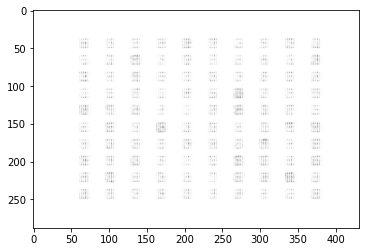

>301, c1=-243.097, c2=-230.362 g=-396.076
>302, c1=-244.740, c2=-229.632 g=-346.961
>303, c1=-245.438, c2=-230.054 g=-333.636
>304, c1=-245.097, c2=-231.945 g=-326.076
>305, c1=-245.794, c2=-233.065 g=-330.245
>306, c1=-247.015, c2=-232.486 g=-304.634
>307, c1=-246.905, c2=-235.191 g=-324.648
>308, c1=-249.599, c2=-236.308 g=-373.591
>309, c1=-249.065, c2=-235.540 g=-315.732
>310, c1=-250.084, c2=-237.144 g=-336.231
>311, c1=-250.151, c2=-236.135 g=-314.452
>312, c1=-252.436, c2=-238.474 g=-311.080
>313, c1=-253.193, c2=-240.330 g=-340.366
>314, c1=-252.716, c2=-238.816 g=-288.622
>315, c1=-255.298, c2=-239.430 g=-279.433
>316, c1=-254.368, c2=-243.373 g=-269.231
>317, c1=-254.458, c2=-244.313 g=-299.679
>318, c1=-257.735, c2=-243.879 g=-321.659
>319, c1=-256.650, c2=-244.143 g=-272.536
>320, c1=-257.791, c2=-244.657 g=-315.832
>321, c1=-259.044, c2=-246.476 g=-286.856
>322, c1=-259.513, c2=-247.821 g=-282.927
>323, c1=-260.118, c2=-243.853 g=-244.708
>324, c1=-260.713, c2=-246.321 g=-

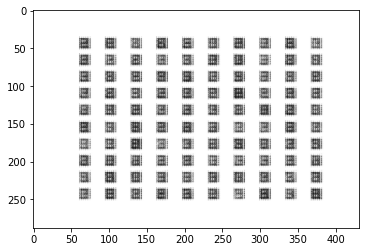

>351, c1=-257.911, c2=-247.260 g=-65.326
>352, c1=-261.319, c2=-250.232 g=-85.872
>353, c1=-263.529, c2=-254.398 g=-77.636
>354, c1=-268.072, c2=-258.362 g=-86.251
>355, c1=-269.051, c2=-263.393 g=-90.657
>356, c1=-273.489, c2=-264.991 g=-107.417
>357, c1=-274.560, c2=-269.622 g=-107.351
>358, c1=-276.501, c2=-272.617 g=-131.250
>359, c1=-279.819, c2=-275.403 g=-129.834
>360, c1=-282.980, c2=-278.258 g=-157.981
>361, c1=-284.333, c2=-281.505 g=-123.004
>362, c1=-286.505, c2=-283.333 g=-140.941
>363, c1=-287.905, c2=-286.108 g=-126.309
>364, c1=-289.332, c2=-288.115 g=-120.360
>365, c1=-291.820, c2=-289.463 g=-143.421
>366, c1=-294.169, c2=-291.519 g=-116.614
>367, c1=-294.932, c2=-292.686 g=-111.734
>368, c1=-296.617, c2=-295.057 g=-94.059
>369, c1=-298.857, c2=-296.604 g=-92.117
>370, c1=-299.686, c2=-298.113 g=-89.764
>371, c1=-302.649, c2=-299.726 g=-98.071
>372, c1=-302.519, c2=-301.119 g=-81.324
>373, c1=-303.936, c2=-302.357 g=-72.057
>374, c1=-304.563, c2=-303.187 g=-73.879
>375

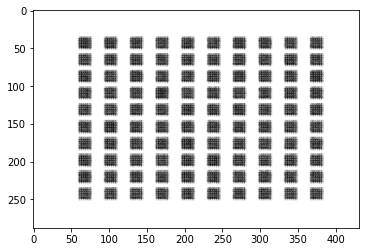

>401, c1=-340.926, c2=-336.064 g=7.119
>402, c1=-341.891, c2=-337.438 g=-1.957
>403, c1=-342.433, c2=-338.429 g=6.125
>404, c1=-345.142, c2=-339.501 g=-13.147
>405, c1=-345.124, c2=-340.680 g=-2.219
>406, c1=-346.193, c2=-341.830 g=2.628
>407, c1=-348.065, c2=-342.756 g=-4.548
>408, c1=-350.443, c2=-344.127 g=2.335
>409, c1=-350.764, c2=-344.963 g=-6.776
>410, c1=-351.292, c2=-346.404 g=2.701
>411, c1=-354.049, c2=-347.386 g=-3.889
>412, c1=-354.690, c2=-348.631 g=0.468
>413, c1=-355.196, c2=-349.993 g=7.401
>414, c1=-357.705, c2=-350.722 g=3.822
>415, c1=-358.380, c2=-352.085 g=9.292
>416, c1=-360.138, c2=-353.279 g=8.552
>417, c1=-361.756, c2=-354.355 g=21.512
>418, c1=-362.637, c2=-355.577 g=20.528
>419, c1=-362.890, c2=-356.604 g=19.999
>420, c1=-363.646, c2=-357.923 g=13.822
>421, c1=-365.448, c2=-359.322 g=10.298
>422, c1=-366.551, c2=-360.477 g=21.393
>423, c1=-368.849, c2=-361.708 g=11.531
>424, c1=-369.134, c2=-362.715 g=19.847
>425, c1=-370.843, c2=-363.890 g=19.242
>426, c1=

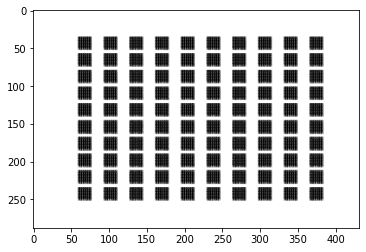

>451, c1=-401.888, c2=-385.206 g=28.614
>452, c1=-402.604, c2=-386.063 g=23.943
>453, c1=-406.133, c2=-386.609 g=36.147
>454, c1=-405.426, c2=-387.309 g=32.574
>455, c1=-407.620, c2=-387.734 g=32.497
>456, c1=-408.373, c2=-387.754 g=23.094
>457, c1=-409.732, c2=-388.522 g=45.762
>458, c1=-411.665, c2=-389.210 g=44.799
>459, c1=-412.572, c2=-389.926 g=29.210
>460, c1=-414.153, c2=-390.885 g=44.963
>461, c1=-415.234, c2=-391.701 g=50.227
>462, c1=-416.988, c2=-392.350 g=40.555
>463, c1=-417.894, c2=-393.552 g=37.027
>464, c1=-419.813, c2=-394.042 g=47.130
>465, c1=-419.456, c2=-395.443 g=55.751
>466, c1=-421.249, c2=-395.685 g=51.300
>467, c1=-422.018, c2=-397.066 g=55.107
>468, c1=-424.335, c2=-397.246 g=46.738
>469, c1=-425.264, c2=-398.324 g=47.424
>470, c1=-426.516, c2=-398.717 g=53.974
>471, c1=-427.466, c2=-399.480 g=46.948
>472, c1=-429.320, c2=-399.810 g=51.532
>473, c1=-430.449, c2=-400.578 g=50.408
>474, c1=-431.742, c2=-401.282 g=55.047
>475, c1=-432.992, c2=-402.391 g=50.429


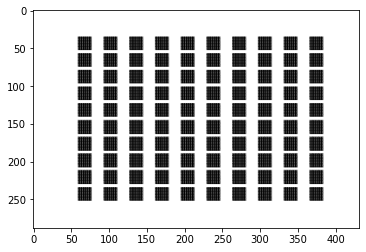

>501, c1=-465.380, c2=-430.627 g=87.185
>502, c1=-465.456, c2=-431.780 g=89.623
>503, c1=-467.075, c2=-432.930 g=71.857
>504, c1=-467.962, c2=-434.101 g=91.816
>505, c1=-470.214, c2=-435.186 g=84.076
>506, c1=-471.515, c2=-436.395 g=96.259
>507, c1=-472.300, c2=-437.485 g=80.241
>508, c1=-473.916, c2=-438.664 g=90.439
>509, c1=-475.438, c2=-439.550 g=81.096
>510, c1=-475.807, c2=-440.626 g=81.945
>511, c1=-475.937, c2=-441.581 g=75.879
>512, c1=-477.970, c2=-442.762 g=77.432
>513, c1=-479.952, c2=-443.815 g=92.014
>514, c1=-480.940, c2=-444.928 g=92.879
>515, c1=-482.531, c2=-446.061 g=86.977
>516, c1=-483.201, c2=-447.325 g=81.285
>517, c1=-485.415, c2=-448.597 g=82.278
>518, c1=-485.435, c2=-449.816 g=91.177
>519, c1=-487.699, c2=-451.025 g=89.470
>520, c1=-488.469, c2=-452.254 g=72.088
>521, c1=-489.635, c2=-453.457 g=83.311
>522, c1=-491.450, c2=-454.667 g=75.194
>523, c1=-492.258, c2=-455.856 g=84.158
>524, c1=-493.499, c2=-457.014 g=89.885
>525, c1=-495.135, c2=-458.249 g=82.839


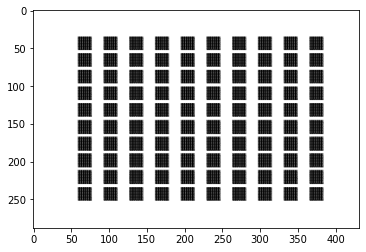

>551, c1=-527.471, c2=-488.771 g=79.243
>552, c1=-529.185, c2=-489.983 g=98.232
>553, c1=-530.783, c2=-491.121 g=101.885
>554, c1=-530.994, c2=-492.260 g=76.290
>555, c1=-532.012, c2=-493.475 g=89.572
>556, c1=-534.471, c2=-494.607 g=93.816
>557, c1=-535.089, c2=-495.818 g=92.607
>558, c1=-536.482, c2=-496.960 g=86.772
>559, c1=-538.238, c2=-498.200 g=97.608
>560, c1=-538.844, c2=-499.281 g=78.615
>561, c1=-541.603, c2=-500.579 g=93.547
>562, c1=-542.846, c2=-501.740 g=96.825
>563, c1=-542.086, c2=-502.970 g=89.288
>564, c1=-543.823, c2=-504.152 g=85.556
>565, c1=-545.694, c2=-505.397 g=102.138
>566, c1=-547.913, c2=-506.513 g=82.474
>567, c1=-548.713, c2=-507.765 g=97.962
>568, c1=-550.795, c2=-508.832 g=88.073
>569, c1=-551.256, c2=-510.195 g=96.324
>570, c1=-553.792, c2=-511.426 g=89.413
>571, c1=-555.335, c2=-512.622 g=91.500
>572, c1=-556.138, c2=-513.840 g=99.455
>573, c1=-556.926, c2=-515.034 g=87.235
>574, c1=-557.340, c2=-516.227 g=99.534
>575, c1=-558.424, c2=-517.403 g=104.7

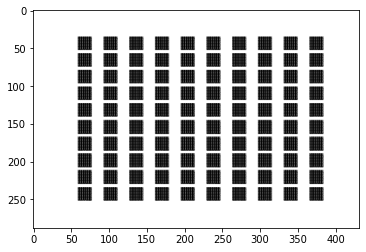

>601, c1=-595.294, c2=-549.170 g=109.065
>602, c1=-594.573, c2=-550.209 g=85.626
>603, c1=-596.242, c2=-551.626 g=98.438
>604, c1=-597.934, c2=-552.707 g=104.181
>605, c1=-599.158, c2=-554.041 g=116.696
>606, c1=-601.693, c2=-555.069 g=87.103
>607, c1=-602.636, c2=-556.515 g=102.094
>608, c1=-602.267, c2=-557.530 g=82.414
>609, c1=-605.040, c2=-558.848 g=95.216
>610, c1=-605.051, c2=-560.072 g=93.551
>611, c1=-607.141, c2=-561.321 g=108.127
>612, c1=-609.247, c2=-562.466 g=99.733
>613, c1=-608.918, c2=-563.823 g=116.030
>614, c1=-611.414, c2=-564.925 g=90.011
>615, c1=-612.207, c2=-566.276 g=107.437
>616, c1=-613.825, c2=-567.391 g=109.390
>617, c1=-615.351, c2=-568.699 g=103.409
>618, c1=-615.804, c2=-569.852 g=82.245
>619, c1=-618.784, c2=-571.251 g=90.952
>620, c1=-619.713, c2=-572.438 g=94.638
>621, c1=-620.576, c2=-573.719 g=85.909
>622, c1=-623.038, c2=-575.042 g=109.871
>623, c1=-623.596, c2=-576.155 g=100.247
>624, c1=-625.399, c2=-577.441 g=86.039
>625, c1=-626.148, c2=-578.70

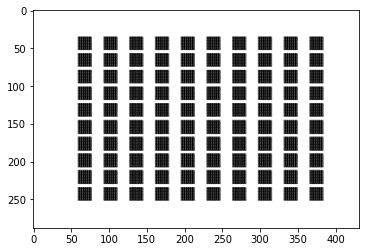

>651, c1=-662.734, c2=-611.546 g=108.158
>652, c1=-664.046, c2=-613.028 g=92.119
>653, c1=-664.152, c2=-614.131 g=91.232
>654, c1=-665.072, c2=-615.690 g=94.491
>655, c1=-666.965, c2=-616.656 g=107.099
>656, c1=-669.430, c2=-618.188 g=95.359
>657, c1=-670.784, c2=-619.297 g=107.760
>658, c1=-672.666, c2=-620.866 g=80.447
>659, c1=-673.588, c2=-622.086 g=112.057
>660, c1=-674.459, c2=-623.226 g=84.542
>661, c1=-675.633, c2=-624.590 g=103.707
>662, c1=-676.929, c2=-625.684 g=82.945
>663, c1=-678.437, c2=-627.200 g=120.081
>664, c1=-679.486, c2=-628.241 g=106.943
>665, c1=-681.833, c2=-629.593 g=95.395
>666, c1=-682.171, c2=-630.877 g=120.049
>667, c1=-684.371, c2=-632.188 g=94.839
>668, c1=-686.291, c2=-633.598 g=107.215
>669, c1=-686.865, c2=-634.758 g=113.422
>670, c1=-688.043, c2=-636.168 g=85.500
>671, c1=-689.290, c2=-637.390 g=109.937
>672, c1=-691.781, c2=-639.050 g=94.632
>673, c1=-692.275, c2=-639.849 g=116.751
>674, c1=-694.871, c2=-641.542 g=107.986
>675, c1=-695.937, c2=-642.

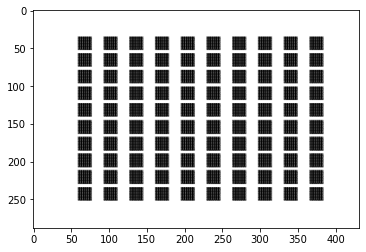

>701, c1=-732.696, c2=-676.632 g=106.321
>702, c1=-734.508, c2=-677.841 g=113.863
>703, c1=-737.187, c2=-679.217 g=101.120
>704, c1=-737.910, c2=-680.562 g=119.988
>705, c1=-738.216, c2=-681.796 g=126.590
>706, c1=-740.221, c2=-683.186 g=109.823
>707, c1=-742.399, c2=-684.467 g=119.684
>708, c1=-743.691, c2=-685.716 g=94.305
>709, c1=-744.334, c2=-686.832 g=113.543
>710, c1=-746.495, c2=-686.820 g=120.668
>711, c1=-747.127, c2=-689.458 g=113.704
>712, c1=-749.244, c2=-690.628 g=106.777
>713, c1=-749.920, c2=-692.588 g=95.998
>714, c1=-751.688, c2=-693.962 g=120.912
>715, c1=-752.303, c2=-695.611 g=91.507
>716, c1=-754.111, c2=-697.248 g=105.883
>717, c1=-755.853, c2=-698.481 g=102.622
>718, c1=-755.888, c2=-700.191 g=124.277
>719, c1=-758.133, c2=-700.934 g=88.504
>720, c1=-759.823, c2=-702.932 g=106.155
>721, c1=-761.654, c2=-703.912 g=103.654
>722, c1=-761.190, c2=-705.508 g=127.063
>723, c1=-766.170, c2=-706.740 g=109.464
>724, c1=-765.919, c2=-708.382 g=88.736
>725, c1=-766.554, c2

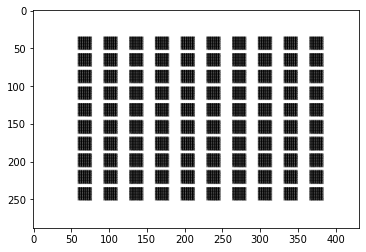

>751, c1=-808.579, c2=-745.528 g=85.149
>752, c1=-807.413, c2=-747.069 g=104.299
>753, c1=-809.481, c2=-748.398 g=92.376
>754, c1=-811.297, c2=-750.254 g=98.742
>755, c1=-811.693, c2=-751.702 g=71.467
>756, c1=-814.075, c2=-753.212 g=80.023
>757, c1=-815.102, c2=-754.444 g=94.798
>758, c1=-817.958, c2=-755.532 g=80.531
>759, c1=-818.198, c2=-757.723 g=93.358
>760, c1=-819.330, c2=-758.444 g=91.691
>761, c1=-821.360, c2=-759.784 g=71.432
>762, c1=-822.353, c2=-761.260 g=98.580
>763, c1=-824.445, c2=-762.524 g=76.113
>764, c1=-825.047, c2=-763.652 g=102.529
>765, c1=-827.552, c2=-765.123 g=72.111
>766, c1=-829.810, c2=-766.559 g=107.093
>767, c1=-831.060, c2=-768.130 g=75.120
>768, c1=-833.231, c2=-769.201 g=68.345
>769, c1=-834.614, c2=-770.845 g=106.587
>770, c1=-835.548, c2=-772.116 g=98.143
>771, c1=-836.856, c2=-773.477 g=103.561
>772, c1=-838.195, c2=-774.881 g=72.113
>773, c1=-840.159, c2=-776.312 g=96.307
>774, c1=-842.726, c2=-777.709 g=77.592
>775, c1=-843.581, c2=-779.183 g=10

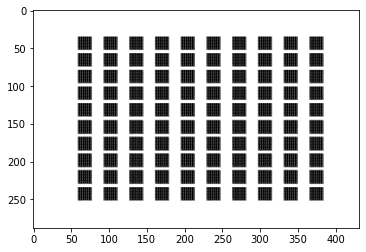

>801, c1=-883.456, c2=-817.385 g=87.030
>802, c1=-885.526, c2=-818.434 g=49.400
>803, c1=-884.652, c2=-820.388 g=88.520
>804, c1=-889.044, c2=-822.062 g=61.664
>805, c1=-890.101, c2=-823.494 g=63.154
>806, c1=-890.754, c2=-824.467 g=82.513
>807, c1=-894.541, c2=-826.423 g=87.809
>808, c1=-894.426, c2=-827.691 g=78.688
>809, c1=-895.778, c2=-828.923 g=82.884
>810, c1=-897.914, c2=-829.786 g=75.972
>811, c1=-899.739, c2=-831.934 g=109.128
>812, c1=-901.112, c2=-832.638 g=91.764
>813, c1=-901.131, c2=-834.134 g=80.982
>814, c1=-903.129, c2=-835.368 g=114.112
>815, c1=-905.377, c2=-836.680 g=97.242
>816, c1=-906.330, c2=-838.609 g=83.506
>817, c1=-908.869, c2=-839.939 g=76.361
>818, c1=-910.068, c2=-841.315 g=120.221
>819, c1=-911.728, c2=-842.741 g=84.251
>820, c1=-914.231, c2=-844.348 g=79.108
>821, c1=-916.028, c2=-845.574 g=106.048
>822, c1=-916.011, c2=-847.397 g=96.031
>823, c1=-918.034, c2=-848.952 g=103.941
>824, c1=-920.134, c2=-850.616 g=80.041
>825, c1=-920.860, c2=-852.367 g=10

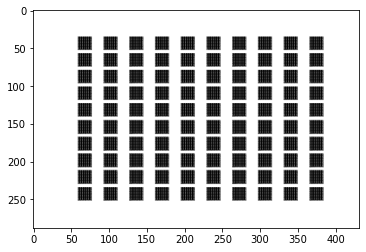

>851, c1=-962.868, c2=-894.831 g=90.007
>852, c1=-964.913, c2=-895.270 g=55.347
>853, c1=-966.940, c2=-896.570 g=89.004
>854, c1=-968.651, c2=-897.476 g=82.640
>855, c1=-971.436, c2=-896.303 g=77.626
>856, c1=-970.601, c2=-898.759 g=74.013
>857, c1=-972.272, c2=-897.536 g=108.097
>858, c1=-973.690, c2=-899.835 g=101.640
>859, c1=-976.611, c2=-900.698 g=73.102
>860, c1=-977.101, c2=-902.153 g=83.623
>861, c1=-979.278, c2=-903.778 g=65.448
>862, c1=-981.534, c2=-905.252 g=107.468
>863, c1=-983.166, c2=-906.902 g=70.903
>864, c1=-984.795, c2=-908.481 g=111.070
>865, c1=-985.567, c2=-910.898 g=76.463
>866, c1=-987.146, c2=-912.756 g=93.520
>867, c1=-988.939, c2=-913.266 g=71.885
>868, c1=-990.855, c2=-914.729 g=94.465
>869, c1=-991.283, c2=-917.117 g=84.333
>870, c1=-995.464, c2=-917.793 g=97.156
>871, c1=-994.766, c2=-919.523 g=53.472
>872, c1=-997.135, c2=-920.776 g=117.344
>873, c1=-999.409, c2=-922.325 g=80.239
>874, c1=-1000.799, c2=-923.960 g=77.171
>875, c1=-1002.277, c2=-925.357 g=

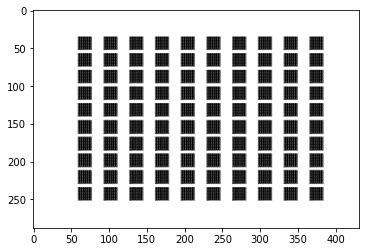

>901, c1=-1045.775, c2=-964.617 g=64.220
>902, c1=-1047.077, c2=-966.264 g=81.606
>903, c1=-1049.459, c2=-968.278 g=83.865
>904, c1=-1052.040, c2=-969.158 g=65.644
>905, c1=-1054.602, c2=-971.674 g=72.449
>906, c1=-1054.806, c2=-971.519 g=96.749
>907, c1=-1057.132, c2=-973.761 g=75.397
>908, c1=-1057.763, c2=-974.801 g=101.357
>909, c1=-1060.593, c2=-977.026 g=59.118
>910, c1=-1063.281, c2=-978.082 g=91.966
>911, c1=-1061.785, c2=-981.154 g=108.426
>912, c1=-1065.907, c2=-981.362 g=63.036
>913, c1=-1065.090, c2=-984.050 g=80.399
>914, c1=-1067.859, c2=-985.197 g=100.253
>915, c1=-1070.398, c2=-988.425 g=115.760
>916, c1=-1070.900, c2=-988.498 g=88.795
>917, c1=-1074.654, c2=-991.987 g=88.857
>918, c1=-1075.056, c2=-992.019 g=64.779
>919, c1=-1076.697, c2=-994.568 g=71.135
>920, c1=-1078.344, c2=-994.941 g=84.588
>921, c1=-1080.975, c2=-997.708 g=65.469
>922, c1=-1081.975, c2=-998.891 g=75.677
>923, c1=-1083.143, c2=-999.244 g=74.343
>924, c1=-1085.734, c2=-1000.349 g=109.476
>925, c1=-

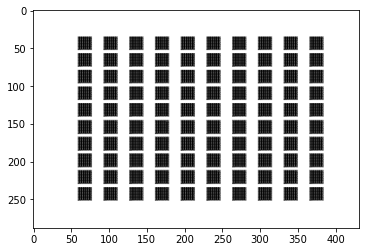

>951, c1=-1131.866, c2=-1044.412 g=95.987
>952, c1=-1134.261, c2=-1044.872 g=63.672
>953, c1=-1133.898, c2=-1047.227 g=63.191
>954, c1=-1137.525, c2=-1049.768 g=86.330
>955, c1=-1139.659, c2=-1051.582 g=81.788
>956, c1=-1139.638, c2=-1053.134 g=94.859
>957, c1=-1140.896, c2=-1054.801 g=75.359
>958, c1=-1143.967, c2=-1058.510 g=103.137
>959, c1=-1145.782, c2=-1057.390 g=85.063
>960, c1=-1147.053, c2=-1060.488 g=108.854
>961, c1=-1149.708, c2=-1060.412 g=85.795
>962, c1=-1151.656, c2=-1063.971 g=78.399
>963, c1=-1152.599, c2=-1062.346 g=87.380
>964, c1=-1155.687, c2=-1065.694 g=80.970
>965, c1=-1157.015, c2=-1066.408 g=113.814
>966, c1=-1157.771, c2=-1068.566 g=89.234
>967, c1=-1159.549, c2=-1069.887 g=89.583
>968, c1=-1163.246, c2=-1070.150 g=87.338
>969, c1=-1164.149, c2=-1071.866 g=97.234
>970, c1=-1165.841, c2=-1073.008 g=85.541
>971, c1=-1166.101, c2=-1073.643 g=76.420
>972, c1=-1168.892, c2=-1076.297 g=113.601
>973, c1=-1169.868, c2=-1076.731 g=95.225
>974, c1=-1169.340, c2=-1078.0

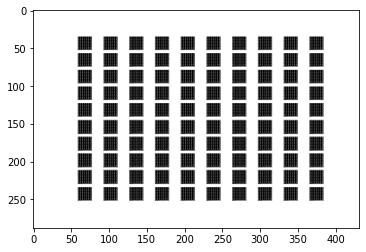

>1001, c1=-1219.520, c2=-1121.396 g=59.755
>1002, c1=-1222.338, c2=-1122.963 g=120.347
>1003, c1=-1222.115, c2=-1124.587 g=103.068
>1004, c1=-1224.966, c2=-1125.521 g=73.417
>1005, c1=-1226.815, c2=-1127.938 g=66.133
>1006, c1=-1230.570, c2=-1129.004 g=110.586
>1007, c1=-1231.449, c2=-1130.855 g=51.383
>1008, c1=-1233.403, c2=-1132.272 g=39.369
>1009, c1=-1235.572, c2=-1134.026 g=61.540
>1010, c1=-1237.797, c2=-1134.622 g=56.963
>1011, c1=-1237.922, c2=-1137.698 g=87.518
>1012, c1=-1239.092, c2=-1137.934 g=59.125
>1013, c1=-1241.990, c2=-1140.935 g=64.767
>1014, c1=-1243.439, c2=-1141.326 g=81.088
>1015, c1=-1245.283, c2=-1144.080 g=89.250
>1016, c1=-1247.741, c2=-1145.043 g=70.942
>1017, c1=-1248.609, c2=-1147.426 g=106.780
>1018, c1=-1251.287, c2=-1148.362 g=59.711
>1019, c1=-1254.970, c2=-1150.923 g=95.676
>1020, c1=-1255.152, c2=-1151.368 g=73.160
>1021, c1=-1257.336, c2=-1154.139 g=50.745
>1022, c1=-1258.832, c2=-1154.920 g=75.363
>1023, c1=-1259.807, c2=-1157.701 g=46.391
>1024, 

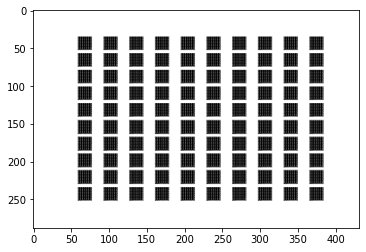

>1051, c1=-1310.775, c2=-1205.189 g=75.834
>1052, c1=-1314.654, c2=-1208.741 g=91.772
>1053, c1=-1315.553, c2=-1209.124 g=112.879
>1054, c1=-1318.594, c2=-1212.551 g=77.417
>1055, c1=-1319.102, c2=-1213.622 g=109.922
>1056, c1=-1322.765, c2=-1216.101 g=83.445
>1057, c1=-1323.537, c2=-1217.163 g=89.003
>1058, c1=-1324.676, c2=-1221.347 g=102.415
>1059, c1=-1327.597, c2=-1221.494 g=139.034
>1060, c1=-1328.146, c2=-1224.790 g=120.902
>1061, c1=-1331.105, c2=-1225.122 g=118.736
>1062, c1=-1332.835, c2=-1228.464 g=121.674
>1063, c1=-1335.666, c2=-1228.706 g=105.952
>1064, c1=-1335.669, c2=-1231.444 g=128.770
>1065, c1=-1340.088, c2=-1231.799 g=97.234
>1066, c1=-1341.081, c2=-1235.079 g=87.554
>1067, c1=-1342.366, c2=-1235.459 g=122.518
>1068, c1=-1343.822, c2=-1238.157 g=81.046
>1069, c1=-1345.798, c2=-1238.394 g=128.325
>1070, c1=-1346.613, c2=-1240.653 g=88.637
>1071, c1=-1349.897, c2=-1241.383 g=84.955
>1072, c1=-1350.016, c2=-1244.654 g=126.822
>1073, c1=-1354.291, c2=-1243.666 g=125.42

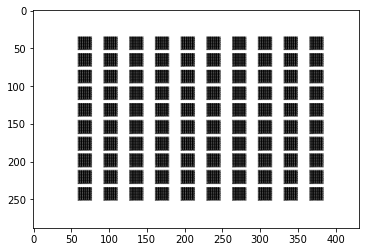

>1101, c1=-1406.845, c2=-1293.709 g=148.885
>1102, c1=-1408.217, c2=-1297.789 g=124.619
>1103, c1=-1410.656, c2=-1297.925 g=153.180
>1104, c1=-1412.068, c2=-1301.563 g=97.070
>1105, c1=-1414.794, c2=-1302.806 g=151.211
>1106, c1=-1416.985, c2=-1305.534 g=123.944
>1107, c1=-1418.668, c2=-1307.525 g=172.029
>1108, c1=-1418.661, c2=-1310.264 g=150.089
>1109, c1=-1421.966, c2=-1312.734 g=135.455
>1110, c1=-1423.144, c2=-1316.325 g=184.705
>1111, c1=-1426.586, c2=-1317.299 g=152.614
>1112, c1=-1427.511, c2=-1320.602 g=175.130
>1113, c1=-1428.153, c2=-1321.945 g=170.394
>1114, c1=-1430.440, c2=-1321.372 g=148.162
>1115, c1=-1434.987, c2=-1323.065 g=130.617
>1116, c1=-1434.210, c2=-1326.076 g=165.906
>1117, c1=-1436.216, c2=-1327.169 g=171.203
>1118, c1=-1438.748, c2=-1329.292 g=108.325
>1119, c1=-1439.218, c2=-1331.865 g=127.170
>1120, c1=-1442.505, c2=-1333.536 g=149.337
>1121, c1=-1444.030, c2=-1335.245 g=147.467
>1122, c1=-1446.697, c2=-1336.886 g=172.035
>1123, c1=-1448.729, c2=-1338.008

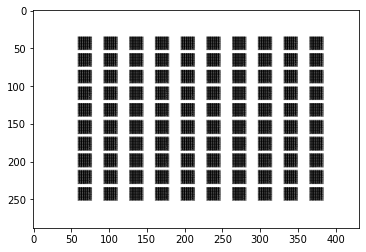

>1151, c1=-1504.624, c2=-1386.988 g=113.824
>1152, c1=-1504.067, c2=-1388.656 g=176.185
>1153, c1=-1508.974, c2=-1389.705 g=106.429
>1154, c1=-1509.858, c2=-1391.436 g=156.745
>1155, c1=-1513.112, c2=-1392.714 g=98.543
>1156, c1=-1513.618, c2=-1393.632 g=142.036
>1157, c1=-1516.227, c2=-1396.189 g=131.264
>1158, c1=-1517.203, c2=-1397.065 g=169.937
>1159, c1=-1519.023, c2=-1399.818 g=158.777
>1160, c1=-1522.449, c2=-1401.335 g=167.421
>1161, c1=-1525.002, c2=-1403.391 g=117.615
>1162, c1=-1525.828, c2=-1405.087 g=197.188
>1163, c1=-1527.174, c2=-1407.862 g=177.785
>1164, c1=-1528.347, c2=-1408.708 g=140.475
>1165, c1=-1530.732, c2=-1412.027 g=156.194
>1166, c1=-1532.867, c2=-1413.393 g=170.133
>1167, c1=-1535.024, c2=-1415.099 g=203.216
>1168, c1=-1537.115, c2=-1416.862 g=140.119
>1169, c1=-1538.516, c2=-1418.675 g=175.533
>1170, c1=-1543.354, c2=-1421.229 g=155.992
>1171, c1=-1543.287, c2=-1422.297 g=191.557
>1172, c1=-1544.832, c2=-1425.264 g=154.557
>1173, c1=-1548.214, c2=-1425.975

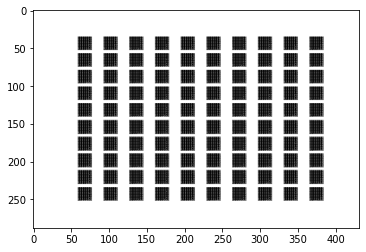

>1201, c1=-1603.704, c2=-1479.409 g=188.187
>1202, c1=-1606.452, c2=-1480.652 g=151.141
>1203, c1=-1606.983, c2=-1483.088 g=182.575
>1204, c1=-1610.762, c2=-1484.318 g=163.266
>1205, c1=-1611.860, c2=-1486.716 g=188.429
>1206, c1=-1614.889, c2=-1487.127 g=179.110
>1207, c1=-1616.989, c2=-1490.611 g=182.694
>1208, c1=-1617.538, c2=-1491.305 g=199.430
>1209, c1=-1619.539, c2=-1493.843 g=164.400
>1210, c1=-1623.582, c2=-1494.930 g=187.467
>1211, c1=-1623.608, c2=-1497.559 g=180.793
>1212, c1=-1626.407, c2=-1497.950 g=186.300
>1213, c1=-1628.356, c2=-1501.581 g=209.742
>1214, c1=-1629.678, c2=-1501.969 g=159.050
>1215, c1=-1632.518, c2=-1505.261 g=190.412
>1216, c1=-1635.879, c2=-1505.598 g=154.904
>1217, c1=-1634.863, c2=-1508.344 g=138.996
>1218, c1=-1639.086, c2=-1509.838 g=153.908
>1219, c1=-1643.384, c2=-1511.781 g=180.601
>1220, c1=-1641.338, c2=-1513.341 g=209.936
>1221, c1=-1644.853, c2=-1516.365 g=157.139
>1222, c1=-1647.270, c2=-1518.518 g=194.450
>1223, c1=-1648.691, c2=-1521.41

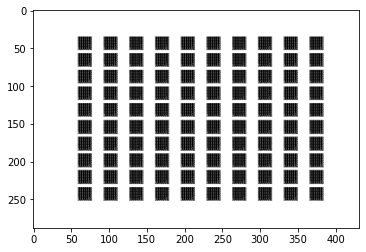

>1251, c1=-1707.227, c2=-1569.408 g=213.811
>1252, c1=-1707.774, c2=-1572.688 g=171.801
>1253, c1=-1710.427, c2=-1573.860 g=196.936
>1254, c1=-1712.022, c2=-1576.313 g=215.814
>1255, c1=-1713.239, c2=-1577.299 g=144.746
>1256, c1=-1716.568, c2=-1581.039 g=198.156
>1257, c1=-1718.891, c2=-1580.648 g=136.519
>1258, c1=-1721.200, c2=-1584.484 g=184.340
>1259, c1=-1725.354, c2=-1584.834 g=220.527
>1260, c1=-1725.795, c2=-1588.251 g=203.007
>1261, c1=-1729.070, c2=-1588.120 g=211.258
>1262, c1=-1729.240, c2=-1591.999 g=153.638
>1263, c1=-1730.906, c2=-1592.776 g=218.154
>1264, c1=-1732.085, c2=-1595.615 g=122.600
>1265, c1=-1733.853, c2=-1596.966 g=187.281
>1266, c1=-1736.915, c2=-1600.316 g=169.213
>1267, c1=-1740.717, c2=-1600.816 g=172.064
>1268, c1=-1739.958, c2=-1604.492 g=210.668
>1269, c1=-1744.451, c2=-1603.693 g=200.579
>1270, c1=-1746.329, c2=-1607.988 g=150.002
>1271, c1=-1749.561, c2=-1608.597 g=211.181
>1272, c1=-1750.987, c2=-1611.675 g=166.479
>1273, c1=-1753.382, c2=-1612.61

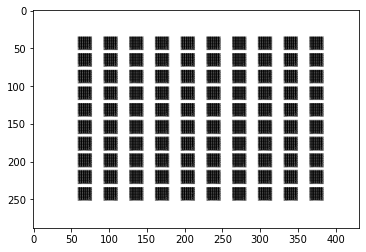

>1301, c1=-1813.320, c2=-1661.250 g=168.198
>1302, c1=-1815.255, c2=-1668.178 g=209.198
>1303, c1=-1817.209, c2=-1664.526 g=172.945
>1304, c1=-1817.619, c2=-1671.543 g=206.763
>1305, c1=-1821.932, c2=-1668.701 g=199.719
>1306, c1=-1824.785, c2=-1673.581 g=203.575
>1307, c1=-1826.916, c2=-1673.462 g=186.751
>1308, c1=-1826.591, c2=-1677.700 g=169.152
>1309, c1=-1829.210, c2=-1677.245 g=224.663
>1310, c1=-1830.484, c2=-1681.835 g=183.658
>1311, c1=-1834.483, c2=-1681.213 g=208.725
>1312, c1=-1836.317, c2=-1685.291 g=183.588
>1313, c1=-1839.701, c2=-1687.446 g=151.685
>1314, c1=-1838.364, c2=-1691.972 g=199.954
>1315, c1=-1840.275, c2=-1692.531 g=173.866
>1316, c1=-1845.458, c2=-1696.662 g=212.316
>1317, c1=-1845.347, c2=-1694.212 g=189.802
>1318, c1=-1846.858, c2=-1699.823 g=168.231
>1319, c1=-1852.502, c2=-1700.205 g=188.802
>1320, c1=-1853.376, c2=-1703.903 g=169.468
>1321, c1=-1856.340, c2=-1704.262 g=221.286
>1322, c1=-1856.172, c2=-1706.324 g=159.292
>1323, c1=-1860.159, c2=-1708.45

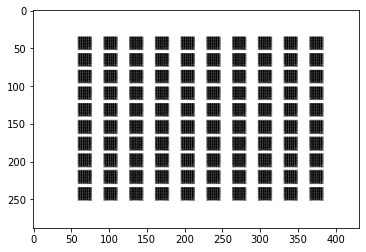

>1351, c1=-1919.963, c2=-1760.714 g=210.093
>1352, c1=-1922.342, c2=-1763.006 g=162.818
>1353, c1=-1925.509, c2=-1765.280 g=226.081
>1354, c1=-1927.877, c2=-1767.428 g=161.067
>1355, c1=-1930.163, c2=-1770.458 g=196.121
>1356, c1=-1930.187, c2=-1772.772 g=178.764
>1357, c1=-1934.527, c2=-1775.634 g=224.265
>1358, c1=-1935.322, c2=-1777.250 g=181.095
>1359, c1=-1936.812, c2=-1780.870 g=181.176
>1360, c1=-1940.149, c2=-1783.011 g=244.611
>1361, c1=-1943.267, c2=-1784.751 g=206.873
>1362, c1=-1946.324, c2=-1788.304 g=175.127
>1363, c1=-1946.261, c2=-1789.689 g=209.100
>1364, c1=-1948.582, c2=-1792.475 g=184.065
>1365, c1=-1952.331, c2=-1794.583 g=241.519
>1366, c1=-1953.565, c2=-1796.995 g=210.707
>1367, c1=-1955.177, c2=-1798.970 g=172.264
>1368, c1=-1960.109, c2=-1801.128 g=226.577
>1369, c1=-1958.622, c2=-1801.130 g=177.550
>1370, c1=-1963.986, c2=-1805.567 g=203.342
>1371, c1=-1965.325, c2=-1807.425 g=164.074
>1372, c1=-1967.157, c2=-1809.519 g=176.894
>1373, c1=-1969.568, c2=-1810.62

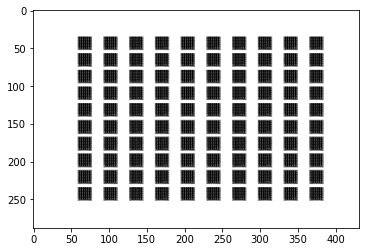

>1401, c1=-2033.326, c2=-1871.774 g=225.163
>1402, c1=-2035.954, c2=-1872.793 g=184.357
>1403, c1=-2036.373, c2=-1875.342 g=251.684
>1404, c1=-2037.656, c2=-1875.437 g=183.209
>1405, c1=-2042.322, c2=-1879.177 g=215.517
>1406, c1=-2043.962, c2=-1881.101 g=161.895
>1407, c1=-2045.811, c2=-1884.072 g=159.235
>1408, c1=-2046.747, c2=-1885.414 g=206.343
>1409, c1=-2050.862, c2=-1888.212 g=230.296
>1410, c1=-2051.594, c2=-1888.137 g=177.997
>1411, c1=-2055.223, c2=-1892.155 g=215.464
>1412, c1=-2054.612, c2=-1892.953 g=155.314
>1413, c1=-2059.301, c2=-1895.709 g=201.642
>1414, c1=-2061.380, c2=-1896.795 g=175.465
>1415, c1=-2063.625, c2=-1898.703 g=228.113
>1416, c1=-2065.539, c2=-1899.606 g=180.706
>1417, c1=-2068.641, c2=-1902.721 g=225.746
>1418, c1=-2068.710, c2=-1904.477 g=160.197
>1419, c1=-2074.578, c2=-1905.230 g=149.393
>1420, c1=-2074.134, c2=-1909.074 g=227.611
>1421, c1=-2077.846, c2=-1909.440 g=141.093
>1422, c1=-2078.919, c2=-1913.494 g=189.909
>1423, c1=-2084.286, c2=-1914.44

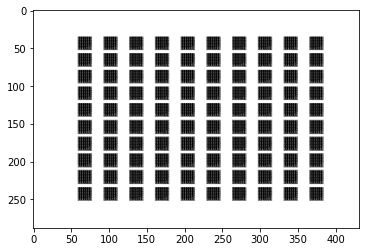

>1451, c1=-2148.758, c2=-1973.321 g=132.057
>1452, c1=-2148.756, c2=-1977.538 g=217.961
>1453, c1=-2152.804, c2=-1978.612 g=188.137
>1454, c1=-2151.086, c2=-1982.167 g=240.289
>1455, c1=-2157.800, c2=-1983.386 g=186.595
>1456, c1=-2158.991, c2=-1985.812 g=190.849
>1457, c1=-2163.695, c2=-1987.883 g=231.326
>1458, c1=-2164.771, c2=-1989.068 g=225.162
>1459, c1=-2163.807, c2=-1955.504 g=207.137
>1460, c1=-2163.636, c2=-1969.162 g=135.447
>1461, c1=-2167.094, c2=-1979.867 g=185.781
>1462, c1=-2167.986, c2=-1984.255 g=153.603
>1463, c1=-2172.085, c2=-1987.814 g=210.881
>1464, c1=-2174.451, c2=-1991.423 g=210.597
>1465, c1=-2177.247, c2=-1993.744 g=207.742
>1466, c1=-2179.324, c2=-1997.296 g=228.089
>1467, c1=-2182.252, c2=-1999.709 g=248.524
>1468, c1=-2181.397, c2=-2002.275 g=244.508
>1469, c1=-2188.248, c2=-2004.384 g=243.555
>1470, c1=-2189.407, c2=-2007.384 g=237.972
>1471, c1=-2190.150, c2=-2009.644 g=281.305
>1472, c1=-2192.152, c2=-2012.405 g=231.357
>1473, c1=-2192.789, c2=-2014.70

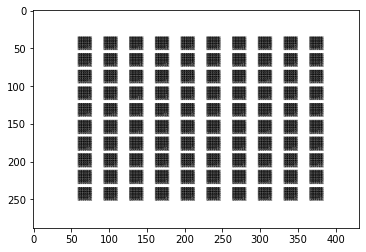

>1501, c1=-2262.134, c2=-2069.872 g=220.349
>1502, c1=-2262.969, c2=-2073.440 g=230.962
>1503, c1=-2266.240, c2=-2075.193 g=280.300
>1504, c1=-2267.594, c2=-2078.196 g=229.043
>1505, c1=-2270.878, c2=-2080.616 g=286.333
>1506, c1=-2273.883, c2=-2083.213 g=218.666
>1507, c1=-2275.595, c2=-2085.408 g=215.122
>1508, c1=-2278.379, c2=-2087.618 g=271.506
>1509, c1=-2280.318, c2=-2088.261 g=216.874
>1510, c1=-2285.250, c2=-2091.022 g=252.304
>1511, c1=-2286.343, c2=-2086.648 g=256.316
>1512, c1=-2287.902, c2=-2087.995 g=275.737
>1513, c1=-2289.239, c2=-2066.524 g=265.300
>1514, c1=-2291.615, c2=-2081.865 g=271.742
>1515, c1=-2296.132, c2=-2086.132 g=263.668
>1516, c1=-2293.499, c2=-2087.028 g=296.568
>1517, c1=-2294.480, c2=-2088.631 g=275.609
>1518, c1=-2297.993, c2=-2088.915 g=302.340
>1519, c1=-2298.518, c2=-2092.298 g=248.869
>1520, c1=-2305.454, c2=-2095.469 g=245.462
>1521, c1=-2306.948, c2=-2100.091 g=248.689
>1522, c1=-2308.239, c2=-2102.057 g=276.059
>1523, c1=-2311.549, c2=-2101.95

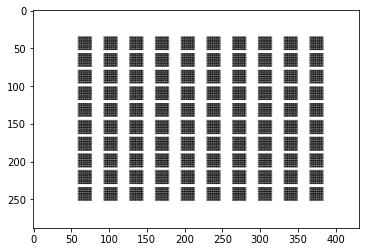

>1551, c1=-2375.347, c2=-2149.340 g=162.312
>1552, c1=-2380.413, c2=-2151.839 g=188.226
>1553, c1=-2382.944, c2=-2153.354 g=97.303
>1554, c1=-2384.563, c2=-2154.876 g=197.489
>1555, c1=-2389.582, c2=-2157.143 g=224.889
>1556, c1=-2390.396, c2=-2159.932 g=135.607
>1557, c1=-2393.658, c2=-2161.196 g=169.048
>1558, c1=-2394.594, c2=-2165.059 g=103.679
>1559, c1=-2399.070, c2=-2164.965 g=161.926
>1560, c1=-2399.959, c2=-2168.270 g=117.423
>1561, c1=-2404.714, c2=-2168.364 g=167.594
>1562, c1=-2406.076, c2=-2171.218 g=77.276
>1563, c1=-2407.203, c2=-2170.738 g=131.728
>1564, c1=-2412.226, c2=-2174.001 g=182.993
>1565, c1=-2414.249, c2=-2174.256 g=105.275
>1566, c1=-2413.779, c2=-2178.642 g=162.697
>1567, c1=-2419.407, c2=-2178.505 g=86.288
>1568, c1=-2424.603, c2=-2183.388 g=125.263
>1569, c1=-2423.302, c2=-2182.935 g=144.414
>1570, c1=-2423.514, c2=-2186.031 g=123.550
>1571, c1=-2428.224, c2=-2189.207 g=173.877
>1572, c1=-2429.490, c2=-2192.770 g=70.598
>1573, c1=-2435.528, c2=-2196.548 g=

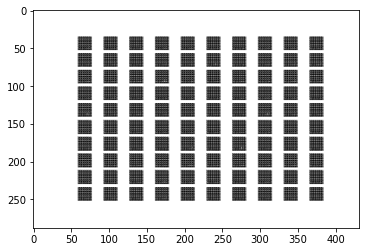

>1601, c1=-2502.948, c2=-2277.247 g=194.843
>1602, c1=-2502.637, c2=-2284.213 g=278.977
>1603, c1=-2507.177, c2=-2285.086 g=182.746
>1604, c1=-2511.249, c2=-2289.537 g=231.438
>1605, c1=-2509.470, c2=-2292.799 g=164.292
>1606, c1=-2515.172, c2=-2295.869 g=279.553
>1607, c1=-2516.859, c2=-2297.854 g=210.561
>1608, c1=-2522.753, c2=-2302.353 g=234.765
>1609, c1=-2520.381, c2=-2301.922 g=291.833
>1610, c1=-2525.900, c2=-2305.343 g=236.583
>1611, c1=-2525.771, c2=-2305.428 g=270.168
>1612, c1=-2531.666, c2=-2300.725 g=231.522
>1613, c1=-2531.599, c2=-2259.586 g=304.455
>1614, c1=-2532.143, c2=-2282.231 g=280.841
>1615, c1=-2536.778, c2=-2288.447 g=285.165
>1616, c1=-2539.197, c2=-2293.338 g=235.548
>1617, c1=-2539.465, c2=-2298.437 g=277.465
>1618, c1=-2545.290, c2=-2302.076 g=286.252
>1619, c1=-2543.209, c2=-2304.688 g=297.546
>1620, c1=-2546.616, c2=-2308.540 g=268.799
>1621, c1=-2550.296, c2=-2310.313 g=249.781
>1622, c1=-2554.498, c2=-2312.410 g=267.790
>1623, c1=-2554.879, c2=-2312.52

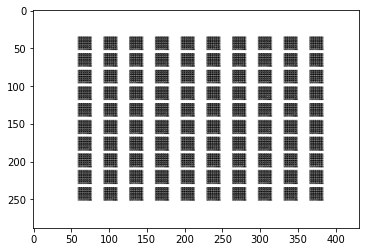

>1651, c1=-2626.010, c2=-2379.658 g=50.105
>1652, c1=-2629.494, c2=-2382.497 g=71.491
>1653, c1=-2632.151, c2=-2384.639 g=149.549
>1654, c1=-2636.430, c2=-2388.783 g=103.082
>1655, c1=-2637.240, c2=-2389.460 g=5.189
>1656, c1=-2639.323, c2=-2394.177 g=120.006
>1657, c1=-2641.872, c2=-2393.910 g=67.109
>1658, c1=-2644.181, c2=-2398.517 g=14.586
>1659, c1=-2648.493, c2=-2400.229 g=106.291
>1660, c1=-2651.098, c2=-2403.837 g=-22.281
>1661, c1=-2653.030, c2=-2408.564 g=10.066
>1662, c1=-2657.897, c2=-2409.214 g=80.281
>1663, c1=-2655.336, c2=-2414.247 g=12.899
>1664, c1=-2659.491, c2=-2417.229 g=13.198
>1665, c1=-2661.377, c2=-2422.091 g=-42.835
>1666, c1=-2661.915, c2=-2422.962 g=33.456
>1667, c1=-2664.845, c2=-2407.204 g=-24.121
>1668, c1=-2668.054, c2=-2415.435 g=25.501
>1669, c1=-2671.395, c2=-2428.895 g=-66.252
>1670, c1=-2675.372, c2=-2432.774 g=-87.260
>1671, c1=-2674.662, c2=-2431.072 g=5.305
>1672, c1=-2681.239, c2=-2436.045 g=-82.917
>1673, c1=-2680.871, c2=-2433.873 g=-33.410
>1

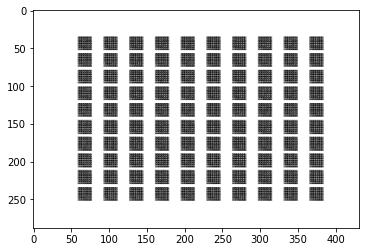

>1701, c1=-2754.062, c2=-2492.376 g=87.000
>1702, c1=-2753.499, c2=-2493.749 g=1.369
>1703, c1=-2760.631, c2=-2498.054 g=81.138
>1704, c1=-2762.660, c2=-2497.859 g=5.513
>1705, c1=-2763.315, c2=-2502.237 g=32.234
>1706, c1=-2766.470, c2=-2504.333 g=75.280
>1707, c1=-2767.073, c2=-2507.289 g=4.742
>1708, c1=-2774.082, c2=-2510.375 g=65.132
>1709, c1=-2777.557, c2=-2513.867 g=-13.134
>1710, c1=-2777.872, c2=-2516.252 g=-37.984
>1711, c1=-2782.388, c2=-2518.306 g=34.034
>1712, c1=-2785.604, c2=-2522.079 g=7.575
>1713, c1=-2783.275, c2=-2524.453 g=-8.846
>1714, c1=-2788.853, c2=-2526.404 g=64.494
>1715, c1=-2790.693, c2=-2528.811 g=73.225
>1716, c1=-2794.271, c2=-2530.791 g=39.417
>1717, c1=-2796.422, c2=-2534.256 g=62.105
>1718, c1=-2799.765, c2=-2536.076 g=43.606
>1719, c1=-2802.514, c2=-2538.763 g=62.770
>1720, c1=-2805.794, c2=-2540.841 g=124.298
>1721, c1=-2807.598, c2=-2542.907 g=71.889
>1722, c1=-2810.175, c2=-2545.520 g=96.720
>1723, c1=-2810.620, c2=-2548.547 g=79.092
>1724, c1=-2

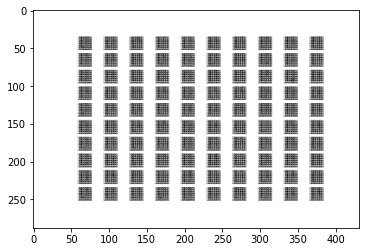

>1751, c1=-2879.521, c2=-2585.939 g=565.338
>1752, c1=-2879.806, c2=-2581.894 g=629.864
>1753, c1=-2883.825, c2=-2591.603 g=661.283
>1754, c1=-2882.258, c2=-2596.583 g=678.769
>1755, c1=-2886.555, c2=-2601.702 g=673.916
>1756, c1=-2888.262, c2=-2605.826 g=630.310
>1757, c1=-2895.283, c2=-2610.646 g=648.074
>1758, c1=-2896.479, c2=-2613.528 g=693.708
>1759, c1=-2898.188, c2=-2617.440 g=699.982
>1760, c1=-2901.502, c2=-2620.980 g=725.485
>1761, c1=-2904.582, c2=-2624.175 g=698.064
>1762, c1=-2903.545, c2=-2628.353 g=702.671
>1763, c1=-2913.828, c2=-2632.529 g=747.163
>1764, c1=-2913.266, c2=-2635.658 g=759.165
>1765, c1=-2916.359, c2=-2638.559 g=733.931
>1766, c1=-2917.064, c2=-2641.386 g=721.819
>1767, c1=-2923.056, c2=-2644.549 g=737.531
>1768, c1=-2925.326, c2=-2647.121 g=703.287
>1769, c1=-2928.090, c2=-2650.986 g=734.010
>1770, c1=-2928.370, c2=-2655.680 g=714.247
>1771, c1=-2931.697, c2=-2660.669 g=737.160
>1772, c1=-2933.742, c2=-2661.226 g=741.074
>1773, c1=-2938.467, c2=-2664.16

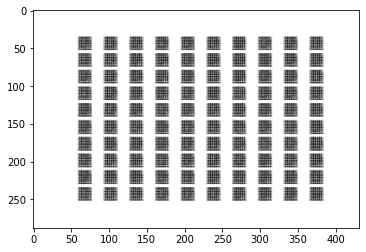

>1801, c1=-3004.646, c2=-2734.040 g=768.813
>1802, c1=-3008.594, c2=-2738.042 g=712.641
>1803, c1=-3011.040, c2=-2741.435 g=575.518
>1804, c1=-3014.173, c2=-2744.067 g=565.931
>1805, c1=-3018.457, c2=-2747.923 g=471.860
>1806, c1=-3021.970, c2=-2751.953 g=512.281
>1807, c1=-3023.311, c2=-2757.129 g=477.419
>1808, c1=-3032.161, c2=-2762.226 g=501.093
>1809, c1=-3031.082, c2=-2767.152 g=510.794
>1810, c1=-3035.450, c2=-2767.867 g=413.329
>1811, c1=-3036.968, c2=-2738.283 g=249.928
>1812, c1=-3036.393, c2=-2696.174 g=412.099
>1813, c1=-3040.214, c2=-2717.201 g=455.587
>1814, c1=-3037.450, c2=-2723.839 g=523.017
>1815, c1=-3041.363, c2=-2734.319 g=527.970
>1816, c1=-3044.807, c2=-2743.131 g=578.382
>1817, c1=-3048.746, c2=-2751.125 g=608.362
>1818, c1=-3049.041, c2=-2758.341 g=597.375
>1819, c1=-3053.035, c2=-2763.408 g=614.630
>1820, c1=-3058.948, c2=-2769.016 g=622.944
>1821, c1=-3058.150, c2=-2773.061 g=617.372
>1822, c1=-3062.012, c2=-2778.084 g=624.799
>1823, c1=-3062.747, c2=-2780.05

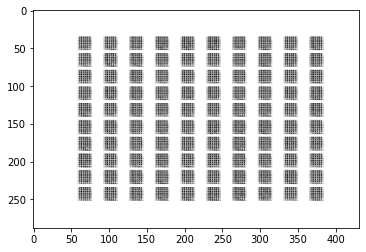

>1851, c1=-3135.280, c2=-2824.279 g=894.110
>1852, c1=-3141.786, c2=-2829.848 g=920.885
>1853, c1=-3138.085, c2=-2834.986 g=931.670
>1854, c1=-3141.303, c2=-2839.600 g=926.609
>1855, c1=-3145.705, c2=-2844.874 g=931.951
>1856, c1=-3147.948, c2=-2846.639 g=963.709
>1857, c1=-3150.002, c2=-2848.127 g=1007.258
>1858, c1=-3150.238, c2=-2853.344 g=1015.035
>1859, c1=-3155.116, c2=-2856.607 g=1064.122
>1860, c1=-3156.840, c2=-2859.435 g=1077.439
>1861, c1=-3157.731, c2=-2857.102 g=1130.052
>1862, c1=-3164.002, c2=-2863.601 g=1131.529
>1863, c1=-3165.226, c2=-2867.640 g=1128.560
>1864, c1=-3167.726, c2=-2871.352 g=1108.513
>1865, c1=-3168.017, c2=-2873.623 g=1073.020
>1866, c1=-3173.585, c2=-2875.594 g=1088.088
>1867, c1=-3175.546, c2=-2878.929 g=1089.906
>1868, c1=-3178.333, c2=-2882.237 g=1118.269
>1869, c1=-3179.431, c2=-2887.170 g=1157.135
>1870, c1=-3182.227, c2=-2878.099 g=1125.286
>1871, c1=-3183.692, c2=-2869.203 g=1158.411
>1872, c1=-3186.338, c2=-2881.183 g=1192.460
>1873, c1=-3186.

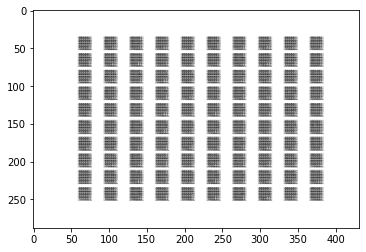

>1901, c1=-3266.479, c2=-2977.494 g=930.599
>1902, c1=-3271.875, c2=-2980.796 g=904.165
>1903, c1=-3276.054, c2=-2976.024 g=866.938
>1904, c1=-3278.362, c2=-2980.795 g=842.737
>1905, c1=-3284.333, c2=-2990.556 g=786.956
>1906, c1=-3279.696, c2=-2990.599 g=709.613
>1907, c1=-3286.067, c2=-2991.822 g=708.638
>1908, c1=-3292.056, c2=-2994.786 g=709.091
>1909, c1=-3296.070, c2=-2999.781 g=756.691
>1910, c1=-3297.494, c2=-3002.288 g=745.702
>1911, c1=-3300.789, c2=-3004.499 g=767.569
>1912, c1=-3305.608, c2=-3006.751 g=785.665
>1913, c1=-3308.754, c2=-3009.865 g=802.493
>1914, c1=-3307.935, c2=-3012.914 g=811.534
>1915, c1=-3311.956, c2=-3014.930 g=799.182
>1916, c1=-3320.133, c2=-3018.281 g=843.340
>1917, c1=-3322.418, c2=-3020.602 g=850.495
>1918, c1=-3325.817, c2=-3023.610 g=831.931
>1919, c1=-3325.406, c2=-3025.906 g=857.732
>1920, c1=-3327.992, c2=-3027.879 g=820.253
>1921, c1=-3336.135, c2=-3030.289 g=796.000
>1922, c1=-3336.477, c2=-3030.549 g=724.474
>1923, c1=-3342.248, c2=-3033.75

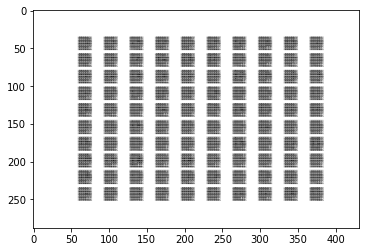

>1951, c1=-3421.750, c2=-3106.552 g=677.980
>1952, c1=-3426.165, c2=-3110.474 g=601.582
>1953, c1=-3427.411, c2=-3109.838 g=694.717
>1954, c1=-3433.741, c2=-3068.520 g=740.025
>1955, c1=-3434.665, c2=-3064.415 g=819.282
>1956, c1=-3431.605, c2=-3086.168 g=774.792
>1957, c1=-3433.368, c2=-3100.824 g=707.333
>1958, c1=-3439.252, c2=-3115.032 g=733.419
>1959, c1=-3443.995, c2=-3118.444 g=712.438
>1960, c1=-3445.150, c2=-3122.323 g=704.167
>1961, c1=-3451.631, c2=-3125.972 g=656.448
>1962, c1=-3452.963, c2=-3128.582 g=732.257
>1963, c1=-3452.950, c2=-3129.807 g=767.810
>1964, c1=-3458.494, c2=-3131.256 g=799.696
>1965, c1=-3462.647, c2=-3126.886 g=869.430
>1966, c1=-3463.978, c2=-3123.260 g=879.246
>1967, c1=-3470.851, c2=-3116.241 g=865.524
>1968, c1=-3471.220, c2=-3123.237 g=894.394
>1969, c1=-3469.306, c2=-3131.014 g=905.281
>1970, c1=-3476.877, c2=-3140.830 g=890.885
>1971, c1=-3479.383, c2=-3145.421 g=890.743
>1972, c1=-3482.513, c2=-3150.690 g=891.958
>1973, c1=-3483.147, c2=-3155.74

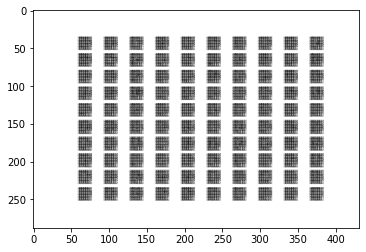

>2001, c1=-3569.822, c2=-3245.124 g=732.871
>2002, c1=-3577.490, c2=-3246.204 g=706.143
>2003, c1=-3579.739, c2=-3250.037 g=707.712
>2004, c1=-3580.170, c2=-3250.302 g=716.451
>2005, c1=-3583.159, c2=-3258.095 g=753.497
>2006, c1=-3585.415, c2=-3259.804 g=715.095
>2007, c1=-3592.159, c2=-3263.800 g=764.891
>2008, c1=-3594.466, c2=-3264.411 g=759.888
>2009, c1=-3598.558, c2=-3271.517 g=768.657
>2010, c1=-3598.454, c2=-3274.292 g=721.557
>2011, c1=-3604.826, c2=-3277.102 g=742.898
>2012, c1=-3605.222, c2=-3280.162 g=747.589
>2013, c1=-3607.735, c2=-3283.040 g=702.623
>2014, c1=-3610.293, c2=-3283.294 g=737.125
>2015, c1=-3615.417, c2=-3286.299 g=681.137
>2016, c1=-3620.516, c2=-3290.942 g=690.794
>2017, c1=-3621.348, c2=-3290.853 g=712.778
>2018, c1=-3626.609, c2=-3295.812 g=684.543
>2019, c1=-3629.021, c2=-3296.205 g=744.535
>2020, c1=-3633.059, c2=-3298.213 g=742.328
>2021, c1=-3632.543, c2=-3302.093 g=751.356
>2022, c1=-3637.417, c2=-3303.602 g=719.495
>2023, c1=-3641.561, c2=-3308.20

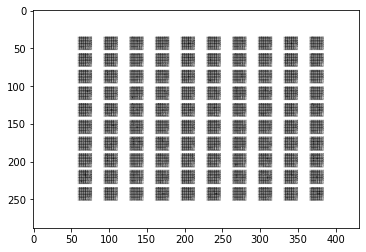

>2051, c1=-3723.790, c2=-3380.800 g=720.786
>2052, c1=-3725.733, c2=-3382.999 g=609.111
>2053, c1=-3730.353, c2=-3384.045 g=652.497
>2054, c1=-3731.863, c2=-3386.067 g=711.887
>2055, c1=-3736.279, c2=-3390.016 g=686.386
>2056, c1=-3739.484, c2=-3389.221 g=680.465
>2057, c1=-3741.708, c2=-3393.614 g=689.624
>2058, c1=-3746.206, c2=-3395.207 g=664.368
>2059, c1=-3748.439, c2=-3400.076 g=716.315
>2060, c1=-3752.307, c2=-3398.225 g=702.855
>2061, c1=-3753.656, c2=-3405.240 g=660.976
>2062, c1=-3758.945, c2=-3407.072 g=677.264
>2063, c1=-3758.305, c2=-3409.513 g=655.540
>2064, c1=-3765.438, c2=-3411.032 g=680.621
>2065, c1=-3768.894, c2=-3413.253 g=610.141
>2066, c1=-3763.449, c2=-3418.073 g=679.770
>2067, c1=-3774.182, c2=-3420.622 g=638.820
>2068, c1=-3773.343, c2=-3424.833 g=657.676
>2069, c1=-3777.499, c2=-3426.003 g=636.256
>2070, c1=-3782.660, c2=-3430.928 g=721.805
>2071, c1=-3784.973, c2=-3431.448 g=633.928
>2072, c1=-3787.656, c2=-3437.069 g=668.912
>2073, c1=-3791.857, c2=-3436.34

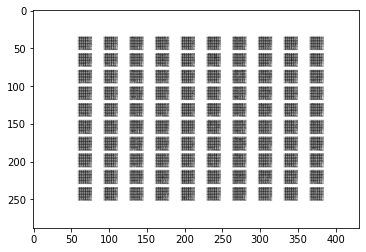

>2101, c1=-3875.270, c2=-3512.830 g=662.341
>2102, c1=-3875.386, c2=-3510.452 g=581.276
>2103, c1=-3882.133, c2=-3517.682 g=672.684
>2104, c1=-3884.824, c2=-3517.789 g=662.025
>2105, c1=-3884.473, c2=-3524.179 g=642.621
>2106, c1=-3890.776, c2=-3525.763 g=622.869
>2107, c1=-3895.812, c2=-3529.107 g=689.981
>2108, c1=-3894.326, c2=-3529.720 g=642.375
>2109, c1=-3900.161, c2=-3536.078 g=703.001
>2110, c1=-3906.968, c2=-3535.046 g=727.159
>2111, c1=-3908.284, c2=-3542.875 g=651.702
>2112, c1=-3908.955, c2=-3543.390 g=680.111
>2113, c1=-3909.257, c2=-3547.359 g=713.705
>2114, c1=-3913.385, c2=-3549.642 g=692.887
>2115, c1=-3921.903, c2=-3552.654 g=660.460
>2116, c1=-3923.403, c2=-3555.590 g=718.729
>2117, c1=-3922.729, c2=-3557.883 g=685.254
>2118, c1=-3927.912, c2=-3561.480 g=617.087
>2119, c1=-3931.977, c2=-3565.053 g=672.026
>2120, c1=-3933.500, c2=-3565.417 g=631.347
>2121, c1=-3937.965, c2=-3572.673 g=676.251
>2122, c1=-3939.780, c2=-3571.603 g=626.418
>2123, c1=-3941.776, c2=-3576.47

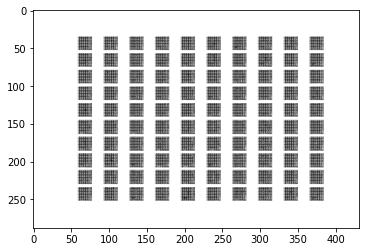

>2151, c1=-4032.320, c2=-3650.060 g=679.370
>2152, c1=-4030.003, c2=-3654.050 g=728.661
>2153, c1=-4036.148, c2=-3653.887 g=689.107
>2154, c1=-4039.407, c2=-3658.838 g=666.412
>2155, c1=-4042.852, c2=-3661.192 g=701.976
>2156, c1=-4041.809, c2=-3664.475 g=666.565
>2157, c1=-4049.498, c2=-3666.139 g=687.558
>2158, c1=-4050.720, c2=-3669.796 g=680.706
>2159, c1=-4055.824, c2=-3671.175 g=615.816
>2160, c1=-4058.248, c2=-3676.425 g=689.012
>2161, c1=-4061.904, c2=-3674.433 g=655.694
>2162, c1=-4060.964, c2=-3682.493 g=720.289
>2163, c1=-4066.400, c2=-3682.678 g=645.021
>2164, c1=-4071.486, c2=-3686.986 g=710.474
>2165, c1=-4076.106, c2=-3687.690 g=663.852
>2166, c1=-4076.445, c2=-3692.496 g=690.757
>2167, c1=-4077.174, c2=-3691.684 g=643.026
>2168, c1=-4083.828, c2=-3697.763 g=649.989
>2169, c1=-4083.007, c2=-3699.221 g=702.859
>2170, c1=-4088.212, c2=-3703.540 g=720.541
>2171, c1=-4090.544, c2=-3703.838 g=653.833
>2172, c1=-4094.797, c2=-3707.120 g=659.469
>2173, c1=-4098.559, c2=-3708.02

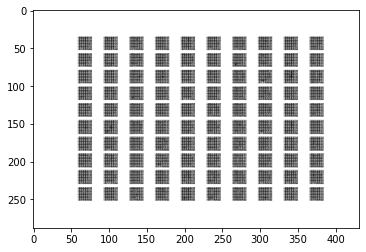

>2201, c1=-4186.761, c2=-3789.821 g=721.416
>2202, c1=-4191.508, c2=-3793.708 g=647.942
>2203, c1=-4192.182, c2=-3797.797 g=714.601
>2204, c1=-4194.145, c2=-3798.066 g=677.750
>2205, c1=-4196.139, c2=-3803.150 g=761.022
>2206, c1=-4202.273, c2=-3800.961 g=668.368
>2207, c1=-4206.236, c2=-3808.671 g=714.806
>2208, c1=-4207.417, c2=-3810.393 g=695.014
>2209, c1=-4210.676, c2=-3814.207 g=748.963
>2210, c1=-4213.087, c2=-3814.167 g=690.900
>2211, c1=-4220.741, c2=-3818.735 g=751.174
>2212, c1=-4218.702, c2=-3819.489 g=673.895
>2213, c1=-4226.368, c2=-3825.068 g=750.757
>2214, c1=-4227.488, c2=-3825.318 g=717.071
>2215, c1=-4230.317, c2=-3829.948 g=666.565
>2216, c1=-4234.158, c2=-3832.039 g=662.363
>2217, c1=-4236.716, c2=-3836.029 g=747.072
>2218, c1=-4235.440, c2=-3834.884 g=702.238
>2219, c1=-4245.329, c2=-3839.962 g=746.714
>2220, c1=-4248.155, c2=-3837.031 g=818.353
>2221, c1=-4251.023, c2=-3830.836 g=830.294
>2222, c1=-4256.787, c2=-3820.901 g=881.142
>2223, c1=-4253.483, c2=-3829.17

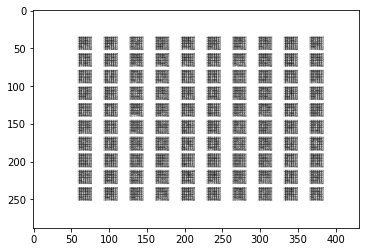

>2251, c1=-4339.422, c2=-3901.757 g=809.136
>2252, c1=-4347.559, c2=-3901.906 g=831.470
>2253, c1=-4350.571, c2=-3903.486 g=810.013
>2254, c1=-4352.150, c2=-3904.786 g=809.590
>2255, c1=-4356.563, c2=-3908.283 g=806.134
>2256, c1=-4358.259, c2=-3911.638 g=826.260
>2257, c1=-4359.932, c2=-3910.416 g=845.231
>2258, c1=-4363.057, c2=-3909.104 g=825.765
>2259, c1=-4368.242, c2=-3915.587 g=837.536
>2260, c1=-4371.444, c2=-3915.016 g=787.290
>2261, c1=-4372.051, c2=-3925.243 g=821.088
>2262, c1=-4377.420, c2=-3924.723 g=814.349
>2263, c1=-4377.101, c2=-3923.381 g=799.992
>2264, c1=-4381.131, c2=-3930.627 g=776.186
>2265, c1=-4384.421, c2=-3929.471 g=793.211
>2266, c1=-4387.913, c2=-3926.987 g=717.493
>2267, c1=-4396.289, c2=-3930.998 g=806.022
>2268, c1=-4398.225, c2=-3929.690 g=822.385
>2269, c1=-4393.578, c2=-3928.740 g=851.822
>2270, c1=-4401.113, c2=-3929.817 g=865.694
>2271, c1=-4400.630, c2=-3939.007 g=858.381
>2272, c1=-4411.226, c2=-3940.109 g=859.689
>2273, c1=-4410.924, c2=-3947.83

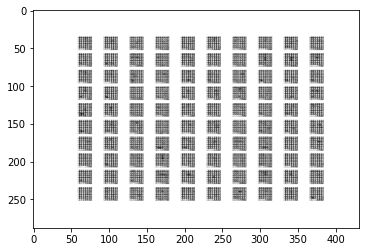

>2301, c1=-4503.990, c2=-4023.809 g=867.592
>2302, c1=-4499.245, c2=-4026.233 g=914.074
>2303, c1=-4502.155, c2=-4032.726 g=856.654
>2304, c1=-4506.184, c2=-4036.579 g=893.089
>2305, c1=-4510.582, c2=-4037.702 g=886.922
>2306, c1=-4513.629, c2=-4034.392 g=931.676
>2307, c1=-4520.193, c2=-4039.452 g=943.815
>2308, c1=-4516.866, c2=-4039.660 g=913.690
>2309, c1=-4519.381, c2=-4041.630 g=1005.290
>2310, c1=-4525.129, c2=-4046.609 g=1005.626
>2311, c1=-4529.300, c2=-4055.665 g=991.666
>2312, c1=-4532.722, c2=-4059.801 g=1032.944
>2313, c1=-4532.156, c2=-4067.255 g=1067.644
>2314, c1=-4535.269, c2=-4068.819 g=1034.707
>2315, c1=-4546.414, c2=-4072.922 g=1066.455
>2316, c1=-4546.811, c2=-4075.105 g=1027.078
>2317, c1=-4551.340, c2=-4080.403 g=1109.374
>2318, c1=-4553.840, c2=-4081.856 g=1036.538
>2319, c1=-4551.440, c2=-4085.484 g=1123.775
>2320, c1=-4557.194, c2=-4084.793 g=1085.662
>2321, c1=-4559.721, c2=-4085.238 g=1085.984
>2322, c1=-4565.006, c2=-4092.327 g=1114.555
>2323, c1=-4569.171

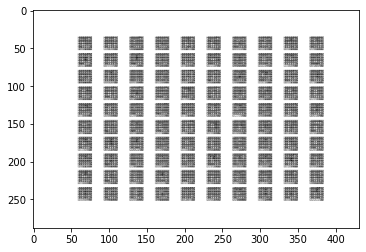

>2351, c1=-4643.899, c2=-4158.458 g=1046.846
>2352, c1=-4641.162, c2=-4156.987 g=1068.827
>2353, c1=-4647.376, c2=-4170.020 g=1043.792
>2354, c1=-4650.462, c2=-4169.869 g=1000.913
>2355, c1=-4654.496, c2=-4176.061 g=930.019
>2356, c1=-4655.331, c2=-4177.553 g=876.378
>2357, c1=-4654.798, c2=-4184.403 g=766.088
>2358, c1=-4659.834, c2=-4191.509 g=771.145
>2359, c1=-4659.740, c2=-4194.035 g=810.477
>2360, c1=-4672.782, c2=-4196.962 g=785.765
>2361, c1=-4677.519, c2=-4199.173 g=692.842
>2362, c1=-4680.133, c2=-4202.463 g=748.630
>2363, c1=-4688.848, c2=-4207.549 g=705.479
>2364, c1=-4690.803, c2=-4211.122 g=720.181
>2365, c1=-4692.004, c2=-4211.623 g=739.455
>2366, c1=-4691.515, c2=-4215.686 g=650.518
>2367, c1=-4697.729, c2=-4219.553 g=608.798
>2368, c1=-4702.981, c2=-4221.977 g=685.427
>2369, c1=-4710.726, c2=-4229.640 g=693.323
>2370, c1=-4713.154, c2=-4226.631 g=716.374
>2371, c1=-4716.170, c2=-4236.801 g=694.957
>2372, c1=-4716.549, c2=-4236.454 g=731.332
>2373, c1=-4725.517, c2=-424

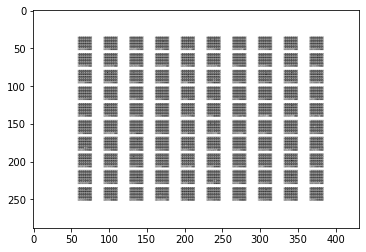

>2401, c1=-4821.724, c2=-4330.842 g=560.052
>2402, c1=-4826.184, c2=-4332.849 g=444.811
>2403, c1=-4827.868, c2=-4334.896 g=605.584
>2404, c1=-4826.230, c2=-4337.005 g=442.537
>2405, c1=-4833.092, c2=-4342.575 g=592.471
>2406, c1=-4835.580, c2=-4342.688 g=397.704
>2407, c1=-4842.166, c2=-4346.860 g=535.284
>2408, c1=-4841.838, c2=-4346.058 g=462.444
>2409, c1=-4849.951, c2=-4350.341 g=540.748
>2410, c1=-4847.810, c2=-4348.490 g=473.907
>2411, c1=-4852.672, c2=-4354.981 g=556.316
>2412, c1=-4859.879, c2=-4352.905 g=462.866
>2413, c1=-4863.266, c2=-4360.550 g=506.021
>2414, c1=-4867.602, c2=-4355.429 g=428.297
>2415, c1=-4863.619, c2=-4362.750 g=538.743
>2416, c1=-4876.149, c2=-4360.899 g=385.343
>2417, c1=-4879.675, c2=-4368.173 g=549.400
>2418, c1=-4878.498, c2=-4368.731 g=619.161
>2419, c1=-4885.195, c2=-4372.393 g=506.466
>2420, c1=-4884.466, c2=-4372.606 g=498.376
>2421, c1=-4897.442, c2=-4377.783 g=584.964
>2422, c1=-4891.588, c2=-4378.039 g=458.984
>2423, c1=-4896.725, c2=-4382.79

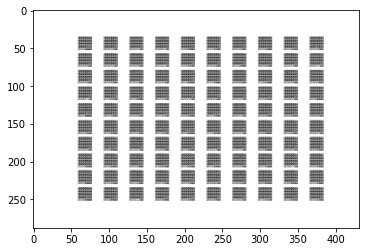

>2451, c1=-4991.439, c2=-4474.586 g=585.182
>2452, c1=-4998.833, c2=-4473.844 g=646.131
>2453, c1=-5003.959, c2=-4478.272 g=542.367
>2454, c1=-5006.554, c2=-4481.621 g=516.105
>2455, c1=-5011.406, c2=-4485.199 g=578.611
>2456, c1=-5010.125, c2=-4487.531 g=593.545
>2457, c1=-5016.439, c2=-4490.868 g=583.453
>2458, c1=-5021.401, c2=-4498.187 g=614.748
>2459, c1=-5019.572, c2=-4497.501 g=643.162
>2460, c1=-5021.263, c2=-4504.372 g=630.788
>2461, c1=-5029.538, c2=-4508.365 g=663.379
>2462, c1=-5033.543, c2=-4513.886 g=657.244
>2463, c1=-5040.364, c2=-4518.953 g=647.658
>2464, c1=-5036.690, c2=-4522.225 g=749.263
>2465, c1=-5045.337, c2=-4528.543 g=766.916
>2466, c1=-5045.865, c2=-4530.906 g=772.634
>2467, c1=-5054.155, c2=-4536.094 g=822.883
>2468, c1=-5055.523, c2=-4539.695 g=839.121
>2469, c1=-5055.595, c2=-4544.947 g=814.931
>2470, c1=-5059.170, c2=-4550.230 g=886.734
>2471, c1=-5061.533, c2=-4553.704 g=903.354
>2472, c1=-5067.875, c2=-4555.472 g=963.849
>2473, c1=-5073.815, c2=-4561.78

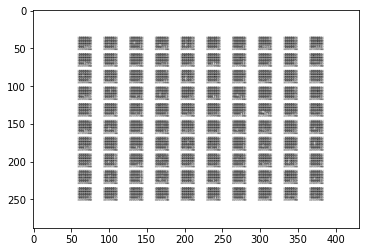

>2501, c1=-5156.955, c2=-4597.973 g=859.141
>2502, c1=-5150.292, c2=-4473.381 g=925.106
>2503, c1=-5139.288, c2=-4523.020 g=1010.332
>2504, c1=-5135.479, c2=-4575.960 g=1029.598
>2505, c1=-5138.165, c2=-4595.204 g=1028.075
>2506, c1=-5134.146, c2=-4602.902 g=1079.176
>2507, c1=-5143.783, c2=-4615.424 g=1060.085
>2508, c1=-5146.942, c2=-4621.709 g=1106.419
>2509, c1=-5152.150, c2=-4621.382 g=1158.427
>2510, c1=-5157.814, c2=-4631.351 g=1183.313
>2511, c1=-5168.566, c2=-4624.407 g=1280.698
>2512, c1=-5172.088, c2=-4630.111 g=1323.109
>2513, c1=-5171.208, c2=-4624.911 g=1363.738
>2514, c1=-5176.727, c2=-4618.328 g=1489.448
>2515, c1=-5180.300, c2=-4621.954 g=1573.222
>2516, c1=-5178.345, c2=-4616.914 g=1663.653
>2517, c1=-5184.802, c2=-4613.710 g=1757.478
>2518, c1=-5188.015, c2=-4616.762 g=1840.656
>2519, c1=-5195.496, c2=-4629.931 g=1887.487
>2520, c1=-5204.415, c2=-4641.894 g=1847.752
>2521, c1=-5210.592, c2=-4654.980 g=1842.020
>2522, c1=-5205.890, c2=-4660.671 g=1869.647
>2523, c1=-5

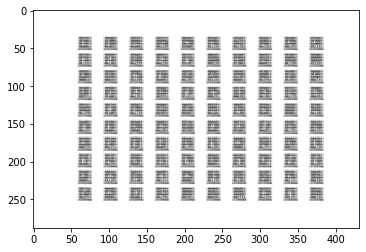

>2551, c1=-5299.052, c2=-4763.025 g=1924.769
>2552, c1=-5304.322, c2=-4764.902 g=1887.776
>2553, c1=-5313.882, c2=-4775.844 g=1893.734
>2554, c1=-5313.682, c2=-4774.170 g=1865.033
>2555, c1=-5312.066, c2=-4783.554 g=1860.123
>2556, c1=-5324.237, c2=-4780.498 g=1829.792
>2557, c1=-5321.269, c2=-4779.878 g=1843.163
>2558, c1=-5329.780, c2=-4782.425 g=1860.671
>2559, c1=-5330.818, c2=-4772.834 g=1896.571
>2560, c1=-5331.433, c2=-4771.819 g=1897.392
>2561, c1=-5337.219, c2=-4783.222 g=1909.660
>2562, c1=-5345.884, c2=-4781.198 g=1956.391
>2563, c1=-5348.150, c2=-4794.933 g=1921.567
>2564, c1=-5357.075, c2=-4800.422 g=1904.526
>2565, c1=-5353.655, c2=-4808.207 g=1952.736
>2566, c1=-5361.601, c2=-4817.502 g=1860.922
>2567, c1=-5366.459, c2=-4820.224 g=1854.042
>2568, c1=-5368.431, c2=-4820.807 g=1857.543
>2569, c1=-5370.631, c2=-4830.615 g=1826.610
>2570, c1=-5375.189, c2=-4833.236 g=1836.835
>2571, c1=-5388.684, c2=-4847.674 g=1859.672
>2572, c1=-5382.151, c2=-4845.866 g=1830.867
>2573, c1=

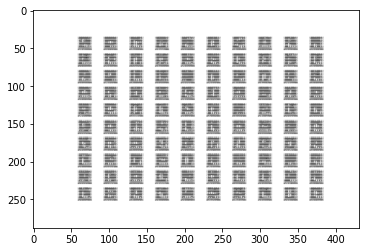

>2601, c1=-5494.210, c2=-4935.647 g=1753.442
>2602, c1=-5496.020, c2=-4937.045 g=1723.149
>2603, c1=-5502.591, c2=-4944.325 g=1709.051
>2604, c1=-5505.596, c2=-4944.764 g=1655.889
>2605, c1=-5507.215, c2=-4948.565 g=1672.467
>2606, c1=-5517.327, c2=-4954.320 g=1663.315
>2607, c1=-5519.762, c2=-4962.823 g=1659.349
>2608, c1=-5518.608, c2=-4954.571 g=1625.325
>2609, c1=-5523.817, c2=-4958.585 g=1651.469
>2610, c1=-5524.070, c2=-4962.972 g=1657.021
>2611, c1=-5533.737, c2=-4966.554 g=1676.655
>2612, c1=-5532.990, c2=-4970.153 g=1670.368
>2613, c1=-5541.131, c2=-4978.499 g=1658.315
>2614, c1=-5543.942, c2=-4980.189 g=1649.834
>2615, c1=-5547.971, c2=-4986.446 g=1632.831
>2616, c1=-5553.074, c2=-4984.264 g=1639.727
>2617, c1=-5560.756, c2=-4982.330 g=1714.039
>2618, c1=-5554.441, c2=-4989.009 g=1662.484
>2619, c1=-5565.161, c2=-4985.606 g=1697.203
>2620, c1=-5569.898, c2=-4977.724 g=1679.917
>2621, c1=-5568.243, c2=-4995.760 g=1672.759
>2622, c1=-5572.688, c2=-4998.470 g=1696.135
>2623, c1=

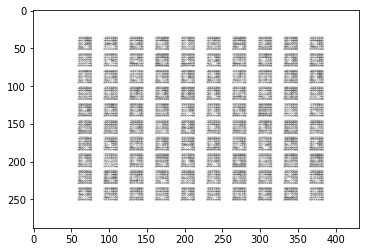

>2651, c1=-5635.493, c2=-4937.851 g=1370.651
>2652, c1=-5627.789, c2=-4926.720 g=1323.404
>2653, c1=-5622.158, c2=-4954.126 g=1399.614
>2654, c1=-5635.988, c2=-4972.531 g=1378.150
>2655, c1=-5642.804, c2=-4987.571 g=1316.845
>2656, c1=-5646.442, c2=-5011.968 g=1241.961
>2657, c1=-5656.431, c2=-5027.447 g=1243.905
>2658, c1=-5661.603, c2=-5047.819 g=1340.116
>2659, c1=-5666.525, c2=-5044.318 g=1394.218
>2660, c1=-5655.691, c2=-5032.968 g=1406.229
>2661, c1=-5668.368, c2=-5028.034 g=1543.483
>2662, c1=-5673.970, c2=-5039.457 g=1681.135
>2663, c1=-5666.173, c2=-5037.154 g=1602.663
>2664, c1=-5666.328, c2=-5044.953 g=1566.814
>2665, c1=-5677.170, c2=-5052.582 g=1572.060
>2666, c1=-5675.298, c2=-5054.171 g=1538.006
>2667, c1=-5680.493, c2=-5070.649 g=1588.715
>2668, c1=-5687.687, c2=-5074.468 g=1603.485
>2669, c1=-5694.580, c2=-5082.425 g=1539.042
>2670, c1=-5695.324, c2=-5089.774 g=1584.243
>2671, c1=-5709.357, c2=-5100.356 g=1513.198
>2672, c1=-5720.813, c2=-5103.378 g=1576.653
>2673, c1=

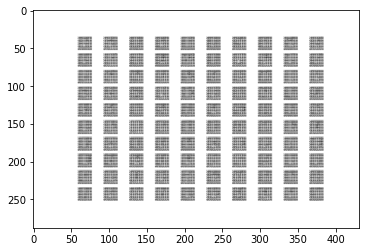

>2701, c1=-5846.442, c2=-5217.577 g=1436.391
>2702, c1=-5853.155, c2=-5226.369 g=1393.950
>2703, c1=-5860.394, c2=-5229.755 g=1433.508
>2704, c1=-5859.743, c2=-5232.623 g=1379.731
>2705, c1=-5870.661, c2=-5230.296 g=1462.875
>2706, c1=-5871.174, c2=-5233.779 g=1506.848
>2707, c1=-5875.959, c2=-5230.500 g=1505.414
>2708, c1=-5883.606, c2=-5231.271 g=1536.848
>2709, c1=-5883.446, c2=-5232.743 g=1534.685
>2710, c1=-5889.429, c2=-5232.465 g=1432.131
>2711, c1=-5891.832, c2=-5230.405 g=1441.744
>2712, c1=-5896.282, c2=-5237.953 g=1447.650
>2713, c1=-5893.041, c2=-5236.104 g=1450.608
>2714, c1=-5902.654, c2=-5236.286 g=1519.427
>2715, c1=-5908.151, c2=-5248.066 g=1538.138
>2716, c1=-5912.070, c2=-5259.598 g=1609.066
>2717, c1=-5909.880, c2=-5259.994 g=1629.224
>2718, c1=-5922.029, c2=-5264.028 g=1711.967
>2719, c1=-5927.833, c2=-5280.251 g=1684.330
>2720, c1=-5927.641, c2=-5272.996 g=1576.650
>2721, c1=-5936.545, c2=-5281.211 g=1614.323
>2722, c1=-5937.605, c2=-5286.716 g=1732.355
>2723, c1=

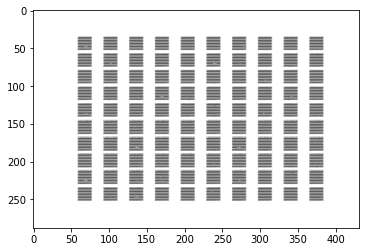

>2751, c1=-6049.860, c2=-5354.864 g=1608.578
>2752, c1=-6056.406, c2=-5357.365 g=1699.881
>2753, c1=-6060.760, c2=-5359.969 g=1578.776
>2754, c1=-6069.886, c2=-5362.167 g=1744.567
>2755, c1=-6071.612, c2=-5356.027 g=1525.077
>2756, c1=-6073.199, c2=-5360.999 g=1601.219
>2757, c1=-6070.032, c2=-5337.847 g=1361.236
>2758, c1=-6082.234, c2=-5320.070 g=1237.783
>2759, c1=-6075.440, c2=-5318.588 g=985.985
>2760, c1=-6076.464, c2=-5355.490 g=958.577
>2761, c1=-6073.223, c2=-5376.430 g=850.076
>2762, c1=-6090.333, c2=-5388.252 g=896.931
>2763, c1=-6086.295, c2=-5393.904 g=762.637
>2764, c1=-6095.112, c2=-5402.749 g=1048.049
>2765, c1=-6112.277, c2=-5405.824 g=986.363
>2766, c1=-6108.390, c2=-5408.769 g=1118.016
>2767, c1=-6103.723, c2=-5411.242 g=1021.391
>2768, c1=-6117.283, c2=-5414.689 g=1144.650
>2769, c1=-6120.534, c2=-5415.085 g=1012.004
>2770, c1=-6127.313, c2=-5418.919 g=1148.309
>2771, c1=-6124.582, c2=-5421.560 g=1017.313
>2772, c1=-6125.587, c2=-5426.321 g=1059.078
>2773, c1=-6137.

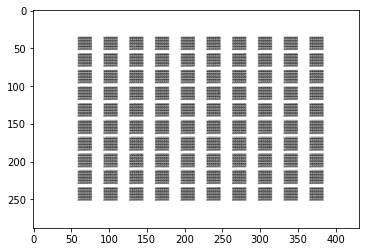

>2801, c1=-6237.186, c2=-5520.147 g=1047.579
>2802, c1=-6242.148, c2=-5526.027 g=1166.984
>2803, c1=-6244.974, c2=-5530.432 g=1177.062
>2804, c1=-6244.005, c2=-5534.083 g=1025.092
>2805, c1=-6257.767, c2=-5538.183 g=1190.799
>2806, c1=-6261.078, c2=-5543.464 g=1052.074
>2807, c1=-6257.654, c2=-5547.801 g=1115.319
>2808, c1=-6273.454, c2=-5552.651 g=1067.440
>2809, c1=-6274.029, c2=-5556.144 g=1206.581
>2810, c1=-6270.545, c2=-5560.546 g=1035.463
>2811, c1=-6286.731, c2=-5565.588 g=1201.307
>2812, c1=-6286.111, c2=-5570.198 g=1228.469
>2813, c1=-6287.605, c2=-5574.503 g=1098.363
>2814, c1=-6295.349, c2=-5580.309 g=1213.970
>2815, c1=-6297.368, c2=-5582.151 g=1185.291
>2816, c1=-6308.270, c2=-5585.611 g=1227.089
>2817, c1=-6306.591, c2=-5590.375 g=1366.396
>2818, c1=-6301.680, c2=-5591.798 g=1311.965
>2819, c1=-6319.072, c2=-5595.353 g=1343.141
>2820, c1=-6311.550, c2=-5593.453 g=1348.972
>2821, c1=-6321.786, c2=-5594.472 g=1232.262
>2822, c1=-6326.305, c2=-5600.105 g=1293.075
>2823, c1=

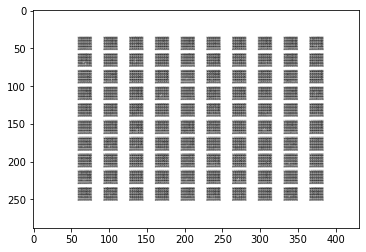

>2851, c1=-6433.527, c2=-5659.387 g=1020.804
>2852, c1=-6434.000, c2=-5508.342 g=1117.565
>2853, c1=-6438.914, c2=-5693.551 g=918.560
>2854, c1=-6449.727, c2=-5705.315 g=914.356
>2855, c1=-6445.448, c2=-5700.284 g=647.538
>2856, c1=-6448.803, c2=-5704.298 g=755.609
>2857, c1=-6454.078, c2=-5706.689 g=619.554
>2858, c1=-6467.690, c2=-5721.125 g=724.617
>2859, c1=-6471.070, c2=-5731.823 g=573.561
>2860, c1=-6468.746, c2=-5733.611 g=771.511
>2861, c1=-6476.187, c2=-5736.531 g=670.016
>2862, c1=-6468.648, c2=-5737.314 g=722.104
>2863, c1=-6486.716, c2=-5746.006 g=684.341
>2864, c1=-6484.674, c2=-5732.657 g=537.241
>2865, c1=-6495.534, c2=-5751.671 g=683.471
>2866, c1=-6494.732, c2=-5751.153 g=577.969
>2867, c1=-6499.311, c2=-5751.360 g=737.775
>2868, c1=-6505.219, c2=-5759.424 g=669.634
>2869, c1=-6505.423, c2=-5756.373 g=739.928
>2870, c1=-6514.631, c2=-5765.315 g=607.504
>2871, c1=-6514.423, c2=-5762.016 g=718.670
>2872, c1=-6525.700, c2=-5770.723 g=653.326
>2873, c1=-6515.257, c2=-5771.

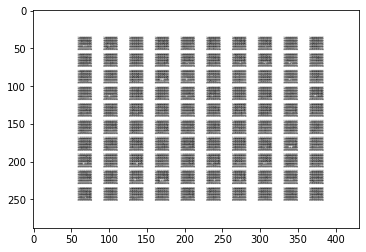

>2901, c1=-6616.120, c2=-5885.220 g=261.930
>2902, c1=-6624.871, c2=-5890.655 g=240.449
>2903, c1=-6619.621, c2=-5904.973 g=123.528
>2904, c1=-6628.816, c2=-5904.044 g=232.029
>2905, c1=-6635.292, c2=-5902.956 g=246.777
>2906, c1=-6628.838, c2=-5904.861 g=220.182
>2907, c1=-6633.322, c2=-5921.221 g=218.396
>2908, c1=-6644.063, c2=-5912.599 g=143.889
>2909, c1=-6652.161, c2=-5924.602 g=212.231
>2910, c1=-6660.865, c2=-5926.173 g=169.164
>2911, c1=-6658.025, c2=-5930.736 g=107.247
>2912, c1=-6654.468, c2=-5941.428 g=210.543
>2913, c1=-6669.512, c2=-5939.209 g=232.743
>2914, c1=-6665.312, c2=-5948.611 g=135.859
>2915, c1=-6663.664, c2=-5947.402 g=232.986
>2916, c1=-6670.724, c2=-5946.052 g=89.266
>2917, c1=-6679.250, c2=-5953.114 g=243.459
>2918, c1=-6681.392, c2=-5956.620 g=351.096
>2919, c1=-6681.738, c2=-5940.556 g=179.600
>2920, c1=-6694.802, c2=-5945.637 g=253.058
>2921, c1=-6692.983, c2=-5937.755 g=215.150
>2922, c1=-6686.168, c2=-5947.022 g=273.884
>2923, c1=-6700.693, c2=-5927.751

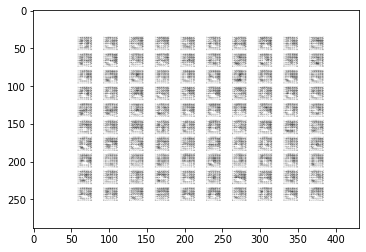

>2951, c1=-6671.894, c2=-5387.526 g=1740.003
>2952, c1=-6650.239, c2=-5374.274 g=1860.120
>2953, c1=-6619.552, c2=-5293.300 g=2117.520
>2954, c1=-6602.313, c2=-5382.854 g=2048.408
>2955, c1=-6593.635, c2=-5423.255 g=2056.361
>2956, c1=-6584.640, c2=-5400.201 g=2284.575
>2957, c1=-6531.925, c2=-5323.989 g=2254.833
>2958, c1=-6521.059, c2=-5194.421 g=2258.548
>2959, c1=-6447.238, c2=-5020.725 g=2274.448
>2960, c1=-6371.522, c2=-4862.768 g=2393.869
>2961, c1=-6268.725, c2=-4395.256 g=2158.733
>2962, c1=-6102.012, c2=-3337.273 g=2117.957
>2963, c1=-5982.776, c2=-3700.876 g=1805.584
>2964, c1=-5927.356, c2=-3853.384 g=1774.608
>2965, c1=-5888.903, c2=-4091.158 g=1668.555
>2966, c1=-5839.373, c2=-4141.549 g=1586.841
>2967, c1=-5751.942, c2=-4189.623 g=1507.311
>2968, c1=-5679.335, c2=-4090.052 g=1520.512
>2969, c1=-5534.984, c2=-4251.760 g=1353.566
>2970, c1=-5442.651, c2=-4194.222 g=1437.217
>2971, c1=-5395.983, c2=-4411.583 g=1241.891
>2972, c1=-5341.505, c2=-4548.151 g=1139.716
>2973, c1=

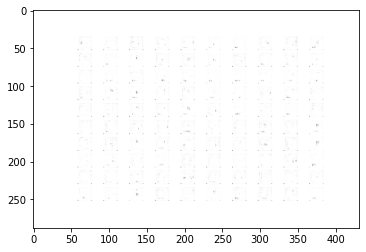

>3001, c1=-6633.320, c2=-5836.817 g=-4876.980
>3002, c1=-6635.638, c2=-5848.375 g=-4934.758
>3003, c1=-6640.165, c2=-5860.554 g=-4952.447
>3004, c1=-6639.529, c2=-5874.344 g=-5422.572
>3005, c1=-6669.481, c2=-5892.737 g=-3833.172
>3006, c1=-6673.585, c2=-5902.362 g=-5185.126
>3007, c1=-6659.383, c2=-5907.775 g=-5542.401
>3008, c1=-6670.585, c2=-5919.280 g=-5882.042
>3009, c1=-6696.070, c2=-5935.948 g=-3953.709
>3010, c1=-6658.555, c2=-5938.043 g=-4982.448
>3011, c1=-6729.205, c2=-5949.971 g=-4871.156
>3012, c1=-6756.506, c2=-5959.318 g=-5360.998
>3013, c1=-6771.018, c2=-5965.729 g=-4653.825
>3014, c1=-6749.682, c2=-5978.241 g=-3782.538
>3015, c1=-6777.269, c2=-5980.146 g=-4776.064
>3016, c1=-6805.953, c2=-5990.358 g=-4955.877
>3017, c1=-6799.145, c2=-6003.419 g=-4609.850
>3018, c1=-6799.904, c2=-6006.717 g=-4527.441
>3019, c1=-6792.440, c2=-6007.894 g=-5403.875
>3020, c1=-6849.981, c2=-6034.177 g=-3091.884
>3021, c1=-6842.459, c2=-6031.797 g=-3890.204
>3022, c1=-6854.945, c2=-6039.365 

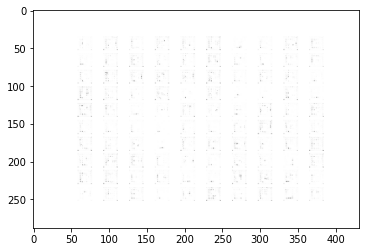

>3051, c1=-7017.863, c2=-6202.589 g=-3710.811
>3052, c1=-6958.797, c2=-6208.246 g=-3464.486
>3053, c1=-7035.599, c2=-6211.703 g=-3440.530
>3054, c1=-7059.486, c2=-6222.217 g=-1662.674
>3055, c1=-7036.753, c2=-6224.539 g=-3425.845
>3056, c1=-7012.190, c2=-6225.167 g=-4405.708
>3057, c1=-7046.188, c2=-6234.122 g=-2751.159
>3058, c1=-7057.445, c2=-6235.303 g=-4055.984
>3059, c1=-7076.289, c2=-6241.955 g=-2272.403
>3060, c1=-7077.352, c2=-6249.511 g=-2807.443
>3061, c1=-7080.859, c2=-6255.572 g=-1456.315
>3062, c1=-7082.258, c2=-6258.762 g=-922.660
>3063, c1=-7073.206, c2=-6260.065 g=-4035.008
>3064, c1=-7077.583, c2=-6268.224 g=-1805.955
>3065, c1=-7109.284, c2=-6272.386 g=-3915.737
>3066, c1=-7117.091, c2=-6279.013 g=-2118.519
>3067, c1=-7085.045, c2=-6279.961 g=-3657.846
>3068, c1=-7123.588, c2=-6287.203 g=-4354.913
>3069, c1=-7104.799, c2=-6288.715 g=-3241.585
>3070, c1=-7128.968, c2=-6292.197 g=-4470.168
>3071, c1=-7134.892, c2=-6297.651 g=-3003.949
>3072, c1=-7142.921, c2=-6302.062 g

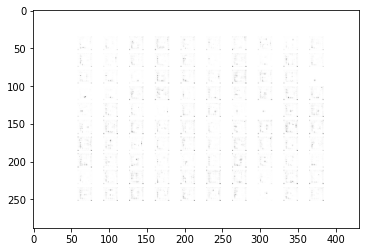

>3101, c1=-7277.218, c2=-6424.079 g=-3590.515
>3102, c1=-7292.663, c2=-6429.883 g=-1738.012
>3103, c1=-7266.062, c2=-6431.841 g=-2004.526
>3104, c1=-7304.306, c2=-6438.375 g=-2115.167
>3105, c1=-7288.471, c2=-6440.597 g=-3883.016
>3106, c1=-7301.537, c2=-6445.727 g=-3397.932
>3107, c1=-7297.814, c2=-6448.689 g=-3660.773
>3108, c1=-7303.867, c2=-6454.109 g=-3007.059
>3109, c1=-7323.930, c2=-6456.975 g=-3664.015
>3110, c1=-7292.024, c2=-6459.935 g=-3596.006
>3111, c1=-7348.910, c2=-6467.045 g=-3111.610
>3112, c1=-7285.167, c2=-6468.447 g=-2275.310
>3113, c1=-7330.977, c2=-6473.465 g=-3046.719
>3114, c1=-7312.883, c2=-6477.599 g=-1294.710
>3115, c1=-7312.757, c2=-6479.111 g=-3821.603
>3116, c1=-7351.874, c2=-6484.581 g=-3213.668
>3117, c1=-7295.245, c2=-6486.582 g=-3564.866
>3118, c1=-7360.483, c2=-6492.412 g=-2303.840
>3119, c1=-7270.975, c2=-6492.689 g=-3934.057
>3120, c1=-7372.778, c2=-6499.967 g=-3106.377
>3121, c1=-7380.922, c2=-6502.841 g=-2946.646
>3122, c1=-7375.776, c2=-6507.054 

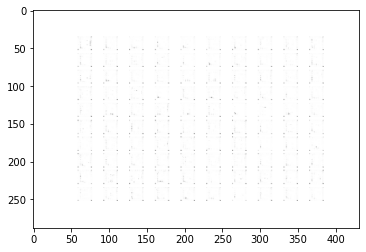

>3151, c1=-7511.164, c2=-6620.138 g=-2813.457
>3152, c1=-7500.224, c2=-6623.663 g=-2585.656
>3153, c1=-7500.102, c2=-6626.804 g=-1814.006
>3154, c1=-7515.733, c2=-6631.399 g=-2440.417
>3155, c1=-7493.704, c2=-6635.202 g=-1844.647
>3156, c1=-7504.812, c2=-6638.034 g=-3639.377
>3157, c1=-7506.890, c2=-6640.881 g=-3919.719
>3158, c1=-7539.551, c2=-6646.346 g=-2785.052
>3159, c1=-7513.760, c2=-6649.618 g=-2283.566
>3160, c1=-7553.379, c2=-6653.365 g=-3053.418
>3161, c1=-7544.785, c2=-6657.305 g=-3045.807
>3162, c1=-7537.930, c2=-6659.965 g=-2344.245
>3163, c1=-7567.259, c2=-6665.505 g=-3015.648
>3164, c1=-7539.793, c2=-6668.854 g=-2231.611
>3165, c1=-7561.600, c2=-6673.671 g=-1962.278
>3166, c1=-7578.974, c2=-6676.347 g=-3130.967
>3167, c1=-7535.895, c2=-6680.504 g=-2395.048
>3168, c1=-7606.954, c2=-6686.377 g=-1629.415
>3169, c1=-7590.350, c2=-6689.034 g=-2745.066
>3170, c1=-7544.925, c2=-6691.321 g=-2913.372
>3171, c1=-7611.215, c2=-6698.129 g=-2081.147
>3172, c1=-7594.534, c2=-6699.709 

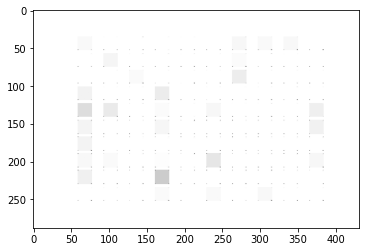

>3201, c1=-7706.810, c2=-6808.978 g=-2700.653
>3202, c1=-7722.666, c2=-6812.588 g=-3429.327
>3203, c1=-7751.462, c2=-6817.364 g=-2087.193
>3204, c1=-7687.743, c2=-6818.101 g=-2600.823
>3205, c1=-7733.277, c2=-6824.925 g=-961.012
>3206, c1=-7733.441, c2=-6828.082 g=-2219.271
>3207, c1=-7751.622, c2=-6831.155 g=-3333.289
>3208, c1=-7735.071, c2=-6832.977 g=-2122.646
>3209, c1=-7762.239, c2=-6838.620 g=-3452.598
>3210, c1=-7754.869, c2=-6841.792 g=-975.228
>3211, c1=-7736.637, c2=-6845.971 g=-1480.665
>3212, c1=-7755.527, c2=-6850.423 g=-2585.444
>3213, c1=-7745.936, c2=-6853.005 g=-1432.926
>3214, c1=-7773.396, c2=-6857.112 g=-3039.367
>3215, c1=-7803.942, c2=-6862.269 g=-3699.576
>3216, c1=-7802.104, c2=-6866.239 g=-2216.603
>3217, c1=-7788.765, c2=-6869.116 g=-4099.263
>3218, c1=-7801.222, c2=-6873.679 g=-1887.789
>3219, c1=-7770.645, c2=-6875.942 g=-4010.181
>3220, c1=-7801.850, c2=-6879.691 g=-4145.761
>3221, c1=-7807.084, c2=-6884.289 g=-3543.871
>3222, c1=-7819.315, c2=-6887.846 g=

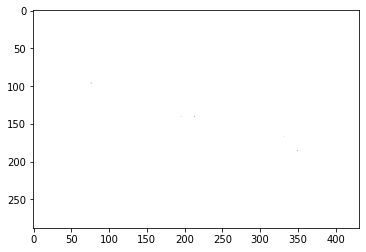

>3251, c1=-7905.633, c2=-6996.199 g=-2510.020
>3252, c1=-7948.875, c2=-7002.172 g=-1642.547
>3253, c1=-7939.259, c2=-7005.035 g=-2905.034
>3254, c1=-7965.932, c2=-7009.877 g=-3071.982
>3255, c1=-7936.954, c2=-7011.534 g=-1492.306
>3256, c1=-7949.075, c2=-7016.275 g=-3747.999
>3257, c1=-7965.671, c2=-7019.688 g=-3235.137
>3258, c1=-7985.729, c2=-7025.974 g=-1506.231
>3259, c1=-7981.807, c2=-7027.373 g=-1666.688
>3260, c1=-7970.722, c2=-7030.881 g=-1713.911
>3261, c1=-7963.884, c2=-7035.270 g=-2245.776
>3262, c1=-7990.568, c2=-7038.755 g=-4222.731
>3263, c1=-7944.137, c2=-7043.098 g=-1419.327
>3264, c1=-8013.351, c2=-7047.753 g=-3734.789
>3265, c1=-7993.692, c2=-7049.878 g=-3508.501
>3266, c1=-8005.071, c2=-7054.321 g=-3316.781
>3267, c1=-7987.338, c2=-7057.563 g=-2464.984
>3268, c1=-8031.070, c2=-7061.719 g=-3749.543
>3269, c1=-8033.416, c2=-7065.610 g=-4196.090
>3270, c1=-8024.071, c2=-7068.114 g=-4033.464
>3271, c1=-8023.958, c2=-7073.128 g=-4112.383
>3272, c1=-8035.976, c2=-7078.306 

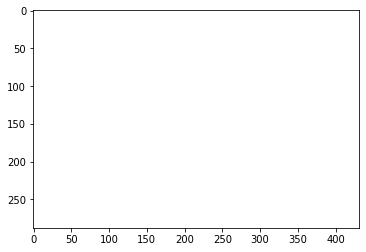

>3301, c1=-8156.749, c2=-7185.502 g=-3624.985
>3302, c1=-8171.396, c2=-7189.859 g=-2602.608
>3303, c1=-8151.754, c2=-7192.607 g=-3590.203
>3304, c1=-8184.119, c2=-7197.997 g=-2454.192
>3305, c1=-8172.317, c2=-7200.833 g=-1259.137
>3306, c1=-8163.103, c2=-7204.826 g=-1516.709
>3307, c1=-8204.759, c2=-7210.159 g=-2801.540
>3308, c1=-8151.224, c2=-7211.030 g=-3185.987
>3309, c1=-8199.275, c2=-7217.071 g=-1288.050
>3310, c1=-8202.557, c2=-7220.159 g=-2834.219
>3311, c1=-8205.446, c2=-7224.265 g=-1517.422
>3312, c1=-8180.710, c2=-7226.122 g=-3804.083
>3313, c1=-8232.003, c2=-7232.062 g=-2433.532
>3314, c1=-8194.026, c2=-7234.893 g=-2749.815
>3315, c1=-8202.542, c2=-7237.675 g=-4114.680
>3316, c1=-8233.241, c2=-7242.362 g=-3576.269
>3317, c1=-8214.260, c2=-7246.188 g=-3122.456
>3318, c1=-8216.609, c2=-7248.951 g=-1880.011
>3319, c1=-8270.912, c2=-7256.776 g=-1993.180
>3320, c1=-8205.793, c2=-7256.848 g=-2710.097
>3321, c1=-8259.096, c2=-7261.742 g=-3547.352
>3322, c1=-8234.267, c2=-7264.101 

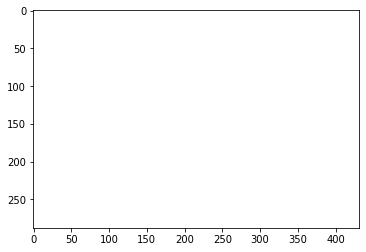

>3351, c1=-8380.085, c2=-7375.894 g=-2262.313
>3352, c1=-8390.239, c2=-7379.585 g=-3357.670
>3353, c1=-8378.036, c2=-7383.617 g=-2748.273
>3354, c1=-8347.416, c2=-7385.893 g=-2796.720
>3355, c1=-8398.704, c2=-7391.171 g=-3327.351
>3356, c1=-8391.094, c2=-7393.575 g=-3368.354
>3357, c1=-8405.760, c2=-7399.124 g=-1664.842
>3358, c1=-8384.159, c2=-7401.593 g=-2944.557
>3359, c1=-8430.070, c2=-7405.777 g=-3464.405
>3360, c1=-8421.352, c2=-7409.342 g=-4063.974
>3361, c1=-8429.389, c2=-7414.721 g=-3756.553
>3362, c1=-8423.817, c2=-7417.731 g=-3005.002
>3363, c1=-8432.350, c2=-7421.641 g=-3675.059
>3364, c1=-8445.643, c2=-7425.285 g=-3021.378
>3365, c1=-8415.769, c2=-7428.181 g=-3310.138
>3366, c1=-8452.460, c2=-7433.763 g=-4182.581
>3367, c1=-8465.157, c2=-7437.939 g=-2950.542
>3368, c1=-8400.128, c2=-7439.605 g=-4057.774
>3369, c1=-8464.107, c2=-7443.978 g=-2901.799
>3370, c1=-8477.705, c2=-7448.079 g=-2999.030
>3371, c1=-8451.063, c2=-7450.626 g=-3447.339
>3372, c1=-8478.266, c2=-7455.437 

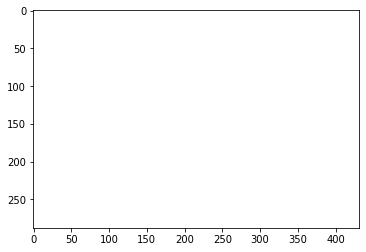

>3401, c1=-8626.771, c2=-7568.581 g=-2328.620
>3402, c1=-8626.652, c2=-7571.047 g=-4175.781
>3403, c1=-8614.365, c2=-7574.618 g=-3715.659
>3404, c1=-8632.597, c2=-7579.648 g=-1158.927
>3405, c1=-8627.317, c2=-7583.020 g=-3237.703
>3406, c1=-8587.806, c2=-7586.769 g=-2865.089
>3407, c1=-8640.378, c2=-7591.375 g=-4092.651
>3408, c1=-8643.182, c2=-7595.321 g=-2658.978
>3409, c1=-8622.661, c2=-7597.645 g=-2552.633
>3410, c1=-8641.888, c2=-7601.804 g=-2710.540
>3411, c1=-8603.665, c2=-7604.391 g=-4183.016
>3412, c1=-8674.025, c2=-7611.171 g=-2427.905
>3413, c1=-8629.917, c2=-7611.655 g=-4267.808
>3414, c1=-8654.246, c2=-7617.160 g=-920.663
>3415, c1=-8676.046, c2=-7622.008 g=-2632.040
>3416, c1=-8661.164, c2=-7625.473 g=-2297.497
>3417, c1=-8685.280, c2=-7630.192 g=-2462.682
>3418, c1=-8678.449, c2=-7631.969 g=-3633.261
>3419, c1=-8674.494, c2=-7635.595 g=-4083.091
>3420, c1=-8687.310, c2=-7640.774 g=-4054.688
>3421, c1=-8650.748, c2=-7644.550 g=-3217.985
>3422, c1=-8704.802, c2=-7649.353 g

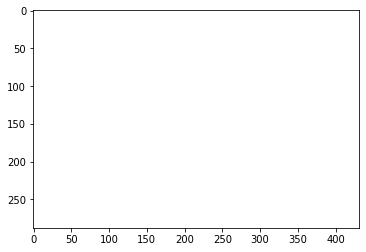

>3451, c1=-8822.567, c2=-7760.326 g=-2165.948
>3452, c1=-8816.313, c2=-7764.360 g=-2771.314
>3453, c1=-8853.999, c2=-7769.598 g=-2863.184
>3454, c1=-8839.452, c2=-7771.503 g=-3708.274
>3455, c1=-8845.859, c2=-7776.620 g=-1826.403
>3456, c1=-8818.949, c2=-7780.090 g=-1654.285
>3457, c1=-8855.254, c2=-7783.953 g=-4074.801
>3458, c1=-8849.066, c2=-7786.734 g=-3584.588
>3459, c1=-8873.919, c2=-7792.223 g=-3142.203
>3460, c1=-8849.980, c2=-7795.169 g=-2803.285
>3461, c1=-8889.677, c2=-7800.300 g=-1509.307
>3462, c1=-8804.494, c2=-7801.320 g=-3364.975
>3463, c1=-8889.515, c2=-7807.810 g=-2503.790
>3464, c1=-8895.078, c2=-7811.185 g=-3201.368
>3465, c1=-8899.647, c2=-7815.816 g=-3020.783
>3466, c1=-8909.684, c2=-7820.479 g=-1731.678
>3467, c1=-8924.109, c2=-7824.694 g=-3132.229
>3468, c1=-8887.013, c2=-7826.851 g=-2012.234
>3469, c1=-8925.934, c2=-7832.729 g=-2307.998
>3470, c1=-8921.236, c2=-7836.501 g=-1972.219
>3471, c1=-8917.896, c2=-7839.941 g=-2387.826
>3472, c1=-8914.873, c2=-7841.913 

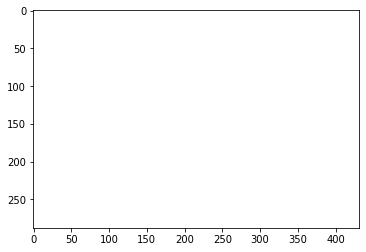

>3501, c1=-9036.862, c2=-7956.116 g=-3711.042
>3502, c1=-9059.373, c2=-7960.328 g=-3131.208
>3503, c1=-9079.521, c2=-7965.323 g=-3872.639
>3504, c1=-9065.718, c2=-7968.937 g=-2344.563
>3505, c1=-9081.017, c2=-7972.892 g=-1768.001
>3506, c1=-9077.022, c2=-7977.380 g=-1772.909
>3507, c1=-9091.289, c2=-7981.376 g=-3248.700
>3508, c1=-9094.910, c2=-7985.789 g=-1682.389
>3509, c1=-9069.667, c2=-7987.448 g=-4647.334
>3510, c1=-9051.079, c2=-7993.022 g=-3365.508
>3511, c1=-9119.041, c2=-7997.440 g=-3760.235
>3512, c1=-9106.381, c2=-8001.260 g=-3571.883
>3513, c1=-9118.137, c2=-8004.479 g=-3976.141
>3514, c1=-9056.738, c2=-8006.607 g=-3745.627
>3515, c1=-9137.441, c2=-8012.753 g=-3062.521
>3516, c1=-9110.810, c2=-8015.287 g=-2322.182
>3517, c1=-9149.050, c2=-8022.013 g=-2338.008
>3518, c1=-9104.579, c2=-8023.444 g=-3482.553
>3519, c1=-9160.790, c2=-8029.189 g=-4187.446
>3520, c1=-9137.381, c2=-8031.538 g=-4050.035
>3521, c1=-9134.045, c2=-8035.031 g=-3506.030
>3522, c1=-9165.868, c2=-8040.310 

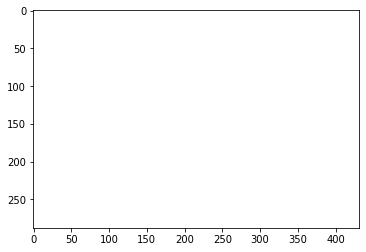

>3551, c1=-9278.275, c2=-8153.902 g=-3973.159
>3552, c1=-9309.645, c2=-8158.944 g=-4259.466
>3553, c1=-9305.256, c2=-8164.055 g=-1712.261
>3554, c1=-9261.578, c2=-8165.309 g=-3767.795
>3555, c1=-9304.165, c2=-8170.487 g=-2124.952
>3556, c1=-9313.552, c2=-8174.897 g=-3787.828
>3557, c1=-9280.621, c2=-8177.818 g=-2169.034
>3558, c1=-9329.542, c2=-8182.447 g=-3124.219
>3559, c1=-9314.077, c2=-8185.745 g=-4232.961
>3560, c1=-9320.381, c2=-8190.343 g=-3172.523
>3561, c1=-9337.817, c2=-8194.251 g=-2950.053
>3562, c1=-9339.469, c2=-8197.789 g=-3633.257
>3563, c1=-9342.181, c2=-8202.071 g=-2443.379
>3564, c1=-9276.748, c2=-8204.151 g=-3475.746
>3565, c1=-9355.837, c2=-8210.656 g=-2386.403
>3566, c1=-9368.679, c2=-8214.280 g=-3703.733
>3567, c1=-9371.040, c2=-8219.220 g=-2822.822
>3568, c1=-9342.354, c2=-8221.342 g=-1825.133
>3569, c1=-9347.234, c2=-8225.132 g=-4772.444
>3570, c1=-9383.886, c2=-8231.972 g=-2642.116
>3571, c1=-9347.808, c2=-8232.776 g=-3434.820
>3572, c1=-9398.771, c2=-8238.761 

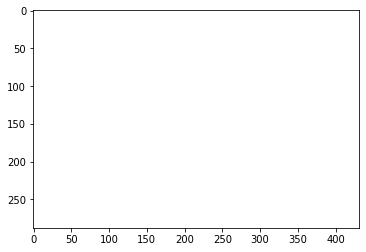

>3601, c1=-9527.413, c2=-8353.298 g=-4546.367
>3602, c1=-9498.539, c2=-8357.465 g=-4385.209
>3603, c1=-9508.871, c2=-8360.184 g=-3817.663
>3604, c1=-9484.457, c2=-8364.746 g=-2371.762
>3605, c1=-9535.249, c2=-8369.242 g=-3512.842
>3606, c1=-9531.775, c2=-8373.313 g=-1565.997
>3607, c1=-9532.019, c2=-8377.138 g=-4181.322
>3608, c1=-9556.827, c2=-8382.174 g=-4037.976
>3609, c1=-9532.650, c2=-8383.847 g=-4754.551
>3610, c1=-9533.303, c2=-8388.384 g=-4742.561
>3611, c1=-9553.898, c2=-8393.559 g=-2822.454
>3612, c1=-9582.195, c2=-8398.191 g=-3641.168
>3613, c1=-9553.184, c2=-8400.588 g=-3790.993
>3614, c1=-9562.735, c2=-8405.156 g=-4475.588
>3615, c1=-9585.402, c2=-8409.578 g=-2929.497
>3616, c1=-9562.505, c2=-8412.929 g=-4565.646
>3617, c1=-9600.603, c2=-8417.591 g=-4291.796
>3618, c1=-9594.794, c2=-8420.608 g=-5281.785
>3619, c1=-9564.745, c2=-8425.347 g=-4379.173
>3620, c1=-9615.243, c2=-8429.983 g=-4541.202
>3621, c1=-9595.129, c2=-8433.574 g=-3193.233
>3622, c1=-9606.737, c2=-8436.041 

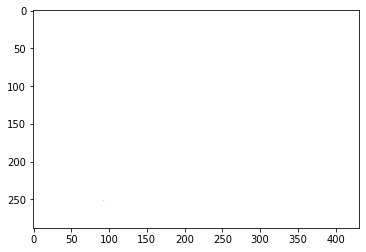

>3651, c1=-9722.301, c2=-8554.065 g=-3915.670
>3652, c1=-9749.099, c2=-8558.543 g=-3753.496
>3653, c1=-9762.925, c2=-8562.696 g=-3188.733
>3654, c1=-9777.524, c2=-8567.564 g=-2154.269
>3655, c1=-9755.671, c2=-8571.526 g=-2581.922
>3656, c1=-9771.901, c2=-8575.512 g=-4313.366
>3657, c1=-9794.379, c2=-8580.515 g=-3029.313
>3658, c1=-9794.720, c2=-8583.004 g=-4344.962
>3659, c1=-9755.878, c2=-8587.936 g=-2329.518
>3660, c1=-9775.143, c2=-8590.957 g=-3237.035
>3661, c1=-9797.818, c2=-8595.633 g=-3200.246
>3662, c1=-9800.672, c2=-8599.953 g=-2019.701
>3663, c1=-9790.698, c2=-8603.482 g=-3096.637
>3664, c1=-9817.749, c2=-8608.214 g=-3275.211
>3665, c1=-9794.479, c2=-8612.307 g=-2756.788
>3666, c1=-9784.938, c2=-8615.683 g=-3191.972
>3667, c1=-9831.356, c2=-8620.315 g=-3624.498
>3668, c1=-9819.828, c2=-8623.804 g=-3065.974
>3669, c1=-9836.493, c2=-8627.781 g=-4502.177
>3670, c1=-9837.791, c2=-8631.925 g=-2390.232
>3671, c1=-9841.504, c2=-8635.099 g=-4126.803
>3672, c1=-9839.534, c2=-8640.250 

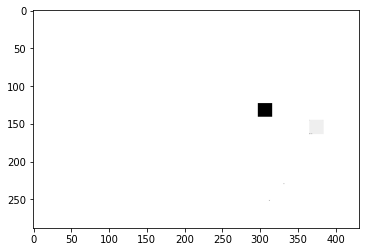

>3701, c1=-9990.424, c2=-8758.965 g=-3685.201
>3702, c1=-10003.226, c2=-8763.521 g=-4295.370
>3703, c1=-9983.312, c2=-8766.980 g=-3673.929
>3704, c1=-10005.765, c2=-8771.347 g=-3957.987
>3705, c1=-9987.924, c2=-8773.950 g=-4492.829
>3706, c1=-9985.028, c2=-8777.518 g=-3662.652
>3707, c1=-9980.523, c2=-8780.992 g=-3345.069
>3708, c1=-10025.717, c2=-8788.156 g=-1915.725
>3709, c1=-9993.929, c2=-8791.129 g=-3356.976
>3710, c1=-10039.792, c2=-8796.146 g=-4306.748
>3711, c1=-10011.167, c2=-8798.495 g=-4414.650
>3712, c1=-10045.011, c2=-8803.249 g=-2555.601
>3713, c1=-10044.024, c2=-8807.248 g=-3897.429
>3714, c1=-10008.891, c2=-8810.652 g=-4678.752
>3715, c1=-10041.476, c2=-8814.920 g=-3396.551
>3716, c1=-10052.201, c2=-8819.459 g=-3448.268
>3717, c1=-10038.398, c2=-8823.125 g=-4799.263
>3718, c1=-10047.210, c2=-8828.749 g=-2428.332
>3719, c1=-10054.376, c2=-8830.960 g=-2477.884
>3720, c1=-10059.016, c2=-8834.984 g=-4208.743
>3721, c1=-10057.843, c2=-8839.857 g=-2865.726
>3722, c1=-10100.59

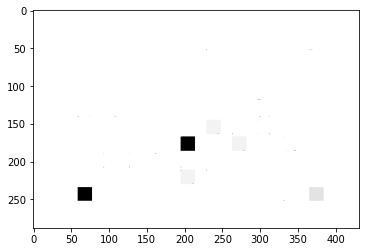

>3751, c1=-10210.632, c2=-8963.591 g=-3057.355
>3752, c1=-10203.955, c2=-8966.940 g=-4131.791
>3753, c1=-10221.421, c2=-8972.632 g=-2400.347
>3754, c1=-10203.583, c2=-8975.926 g=-4049.719
>3755, c1=-10254.479, c2=-8981.202 g=-2554.065
>3756, c1=-10266.970, c2=-8985.912 g=-4551.767
>3757, c1=-10252.695, c2=-8987.758 g=-5482.628
>3758, c1=-10253.493, c2=-8993.152 g=-3312.438
>3759, c1=-10226.710, c2=-8995.678 g=-3602.604
>3760, c1=-10277.072, c2=-9002.139 g=-2276.625
>3761, c1=-10280.545, c2=-9005.374 g=-4368.152
>3762, c1=-10253.713, c2=-9007.686 g=-4611.537
>3763, c1=-10291.653, c2=-9013.908 g=-2049.174
>3764, c1=-10237.357, c2=-9015.689 g=-2317.583
>3765, c1=-10299.839, c2=-9023.280 g=-3827.570
>3766, c1=-10305.313, c2=-9026.798 g=-3594.824
>3767, c1=-10269.650, c2=-9028.460 g=-4288.607
>3768, c1=-10288.496, c2=-9032.363 g=-1710.425
>3769, c1=-10306.646, c2=-9039.146 g=-3083.751
>3770, c1=-10299.098, c2=-9042.782 g=-2936.321
>3771, c1=-10328.033, c2=-9047.236 g=-2058.183
>3772, c1=-10

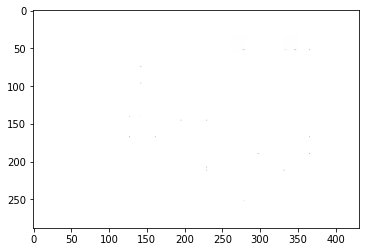

>3801, c1=-10476.107, c2=-9172.393 g=-2532.084
>3802, c1=-10484.123, c2=-9175.790 g=-4477.668
>3803, c1=-10442.591, c2=-9177.876 g=-5158.365
>3804, c1=-10453.878, c2=-9183.400 g=-4140.878
>3805, c1=-10487.976, c2=-9188.458 g=-3712.787
>3806, c1=-10477.544, c2=-9192.504 g=-3161.179
>3807, c1=-10484.133, c2=-9196.496 g=-2149.323
>3808, c1=-10509.587, c2=-9202.477 g=-2626.415
>3809, c1=-10511.422, c2=-9205.678 g=-2620.257
>3810, c1=-10520.164, c2=-9208.984 g=-4086.346
>3811, c1=-10463.341, c2=-9211.636 g=-4038.299
>3812, c1=-10492.885, c2=-9217.393 g=-2864.655
>3813, c1=-10530.553, c2=-9222.836 g=-2401.273
>3814, c1=-10530.465, c2=-9226.719 g=-4372.337
>3815, c1=-10504.270, c2=-9229.660 g=-3784.903
>3816, c1=-10535.315, c2=-9234.202 g=-2097.536
>3817, c1=-10515.564, c2=-9237.856 g=-3650.240
>3818, c1=-10545.650, c2=-9242.559 g=-3342.085
>3819, c1=-10563.819, c2=-9248.387 g=-3526.550
>3820, c1=-10560.773, c2=-9251.027 g=-4075.341
>3821, c1=-10547.571, c2=-9254.738 g=-3457.870
>3822, c1=-10

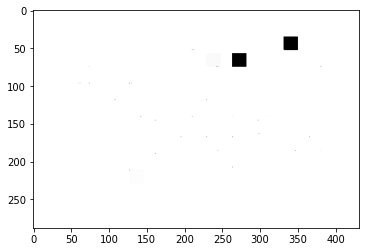

>3851, c1=-10711.814, c2=-9382.177 g=-3409.426
>3852, c1=-10681.160, c2=-9384.192 g=-3639.481
>3853, c1=-10717.730, c2=-9389.095 g=-4915.398
>3854, c1=-10710.598, c2=-9394.538 g=-3949.893
>3855, c1=-10715.968, c2=-9396.511 g=-2285.204
>3856, c1=-10718.670, c2=-9401.548 g=-3280.989
>3857, c1=-10707.017, c2=-9404.558 g=-4983.239
>3858, c1=-10708.607, c2=-9409.009 g=-2745.102
>3859, c1=-10765.281, c2=-9415.587 g=-4561.014
>3860, c1=-10726.097, c2=-9418.262 g=-5014.550
>3861, c1=-10741.856, c2=-9423.893 g=-4465.873
>3862, c1=-10722.129, c2=-9426.945 g=-3817.059
>3863, c1=-10754.257, c2=-9432.250 g=-5359.250
>3864, c1=-10779.457, c2=-9437.143 g=-3263.335
>3865, c1=-10788.181, c2=-9441.457 g=-2737.281
>3866, c1=-10766.848, c2=-9442.859 g=-5073.214
>3867, c1=-10774.075, c2=-9448.356 g=-2950.445
>3868, c1=-10763.657, c2=-9451.349 g=-4757.171
>3869, c1=-10804.280, c2=-9458.704 g=-3816.681
>3870, c1=-10783.896, c2=-9459.774 g=-2821.347
>3871, c1=-10782.151, c2=-9465.122 g=-4776.854
>3872, c1=-10

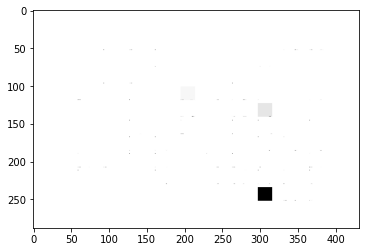

>3901, c1=-10957.247, c2=-9592.695 g=-4620.184
>3902, c1=-10961.871, c2=-9596.617 g=-4007.814
>3903, c1=-10931.526, c2=-9601.502 g=-2140.498
>3904, c1=-10934.158, c2=-9605.645 g=-4789.352
>3905, c1=-10972.728, c2=-9609.731 g=-3280.760
>3906, c1=-10978.916, c2=-9614.972 g=-3776.943
>3907, c1=-10946.779, c2=-9617.008 g=-4984.290
>3908, c1=-10983.513, c2=-9623.424 g=-3285.132
>3909, c1=-10986.346, c2=-9627.949 g=-3719.786
>3910, c1=-11018.761, c2=-9632.297 g=-4813.434
>3911, c1=-10937.284, c2=-9634.823 g=-3752.696
>3912, c1=-11038.443, c2=-9642.114 g=-2611.062
>3913, c1=-11005.369, c2=-9644.639 g=-4446.225
>3914, c1=-10994.720, c2=-9647.553 g=-4078.684
>3915, c1=-11034.603, c2=-9654.384 g=-4530.009
>3916, c1=-11048.350, c2=-9658.402 g=-3385.039
>3917, c1=-10979.422, c2=-9659.324 g=-5045.106
>3918, c1=-11033.480, c2=-9666.282 g=-3034.674
>3919, c1=-11000.479, c2=-9669.238 g=-3126.894
>3920, c1=-11063.835, c2=-9675.842 g=-3513.602
>3921, c1=-11056.121, c2=-9678.785 g=-3162.722
>3922, c1=-11

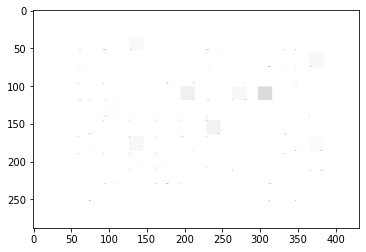

>3951, c1=-11167.800, c2=-9806.806 g=-3551.588
>3952, c1=-11155.606, c2=-9811.385 g=-2216.639
>3953, c1=-11202.815, c2=-9817.032 g=-4245.507
>3954, c1=-11221.619, c2=-9820.915 g=-4171.430
>3955, c1=-11185.104, c2=-9822.347 g=-6117.403
>3956, c1=-11216.995, c2=-9829.467 g=-3997.937
>3957, c1=-11191.206, c2=-9832.002 g=-3025.640
>3958, c1=-11247.612, c2=-9840.101 g=-4084.725
>3959, c1=-11229.371, c2=-9842.069 g=-4129.418
>3960, c1=-11249.987, c2=-9847.024 g=-4677.111
>3961, c1=-11248.323, c2=-9850.918 g=-2562.367
>3962, c1=-11245.707, c2=-9853.688 g=-4265.490
>3963, c1=-11246.867, c2=-9858.618 g=-4605.658
>3964, c1=-11258.303, c2=-9864.009 g=-2612.122
>3965, c1=-11279.952, c2=-9869.210 g=-3239.799
>3966, c1=-11224.030, c2=-9870.218 g=-5143.841
>3967, c1=-11297.492, c2=-9877.094 g=-3814.397
>3968, c1=-11274.755, c2=-9880.891 g=-3042.573
>3969, c1=-11265.962, c2=-9883.935 g=-3530.766
>3970, c1=-11294.563, c2=-9890.467 g=-4966.657
>3971, c1=-11262.546, c2=-9892.445 g=-4587.824
>3972, c1=-11

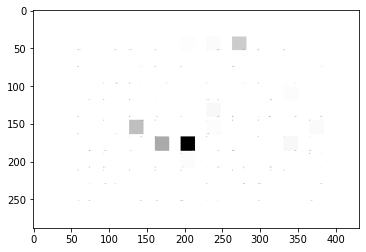

>4001, c1=-11445.802, c2=-10023.748 g=-1999.540
>4002, c1=-11452.803, c2=-10027.836 g=-4446.677
>4003, c1=-11480.457, c2=-10033.836 g=-3588.134
>4004, c1=-11453.598, c2=-10035.721 g=-2288.388
>4005, c1=-11465.653, c2=-10041.779 g=-4430.404
>4006, c1=-11467.833, c2=-10044.579 g=-2445.458
>4007, c1=-11494.789, c2=-10050.461 g=-2624.744
>4008, c1=-11478.002, c2=-10054.568 g=-4250.580
>4009, c1=-11496.724, c2=-10058.842 g=-2939.805
>4010, c1=-11423.705, c2=-10061.711 g=-3391.023
>4011, c1=-11479.223, c2=-10067.706 g=-5355.976
>4012, c1=-11482.021, c2=-10069.886 g=-5971.268
>4013, c1=-11512.043, c2=-10076.873 g=-4025.841
>4014, c1=-11514.709, c2=-10080.364 g=-2187.879
>4015, c1=-11522.833, c2=-10085.112 g=-3423.592
>4016, c1=-11516.041, c2=-10088.678 g=-3570.669
>4017, c1=-11498.933, c2=-10091.303 g=-3584.381
>4018, c1=-11530.369, c2=-10098.636 g=-1456.569
>4019, c1=-11530.329, c2=-10101.207 g=-5041.074
>4020, c1=-11507.975, c2=-10106.659 g=-5454.542
>4021, c1=-11545.382, c2=-10110.466 g=-5

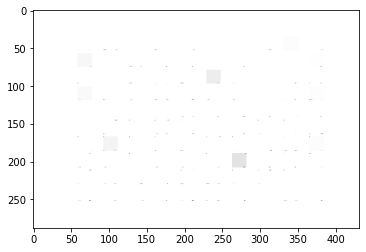

>4051, c1=-11705.603, c2=-10242.404 g=-4107.346
>4052, c1=-11711.494, c2=-10247.244 g=-4282.476
>4053, c1=-11728.650, c2=-10251.513 g=-3358.242
>4054, c1=-11703.574, c2=-10254.462 g=-4344.134
>4055, c1=-11704.625, c2=-10257.965 g=-4517.169
>4056, c1=-11752.241, c2=-10265.891 g=-4329.224
>4057, c1=-11705.612, c2=-10268.127 g=-4123.038
>4058, c1=-11733.542, c2=-10273.768 g=-1899.307
>4059, c1=-11727.638, c2=-10276.463 g=-5009.294
>4060, c1=-11768.132, c2=-10283.789 g=-4015.348
>4061, c1=-11656.658, c2=-10283.189 g=-5299.154
>4062, c1=-11754.726, c2=-10289.544 g=-5148.271
>4063, c1=-11773.432, c2=-10295.439 g=-3970.173
>4064, c1=-11775.326, c2=-10300.416 g=-3572.354
>4065, c1=-11711.311, c2=-10299.827 g=-3473.448
>4066, c1=-11781.723, c2=-10309.029 g=-3542.487
>4067, c1=-11796.333, c2=-10313.884 g=-2583.459
>4068, c1=-11762.496, c2=-10315.158 g=-5001.671
>4069, c1=-11789.435, c2=-10320.540 g=-5023.092
>4070, c1=-11772.075, c2=-10325.283 g=-3861.431
>4071, c1=-11819.123, c2=-10332.208 g=-3

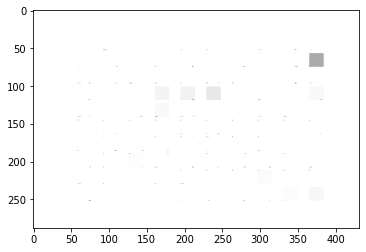

>4101, c1=-11924.438, c2=-10460.823 g=-4835.567
>4102, c1=-11964.146, c2=-10468.890 g=-5662.662
>4103, c1=-11940.216, c2=-10473.303 g=-4521.228
>4104, c1=-11979.573, c2=-10476.483 g=-3341.822
>4105, c1=-11980.115, c2=-10480.924 g=-4187.868
>4106, c1=-11965.161, c2=-10484.923 g=-4689.334
>4107, c1=-11993.379, c2=-10491.118 g=-3576.509
>4108, c1=-11988.735, c2=-10494.314 g=-2273.640
>4109, c1=-11990.849, c2=-10499.920 g=-3918.749
>4110, c1=-12005.638, c2=-10503.664 g=-3928.009
>4111, c1=-12006.190, c2=-10509.301 g=-5839.637
>4112, c1=-12008.532, c2=-10512.053 g=-4636.335
>4113, c1=-12018.822, c2=-10517.078 g=-6131.899
>4114, c1=-12026.574, c2=-10521.767 g=-4341.000
>4115, c1=-11996.820, c2=-10523.714 g=-4210.729
>4116, c1=-12014.679, c2=-10529.214 g=-2893.406
>4117, c1=-12024.200, c2=-10534.450 g=-6398.932
>4118, c1=-12029.023, c2=-10537.541 g=-3833.486
>4119, c1=-12075.739, c2=-10545.922 g=-3341.158
>4120, c1=-12049.475, c2=-10546.735 g=-2682.186
>4121, c1=-12068.114, c2=-10552.580 g=-4

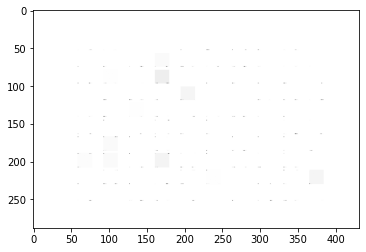

>4151, c1=-12210.557, c2=-10686.913 g=-3059.626
>4152, c1=-12203.339, c2=-10690.591 g=-3885.470
>4153, c1=-12249.108, c2=-10696.821 g=-2432.575
>4154, c1=-12232.466, c2=-10700.038 g=-6346.028
>4155, c1=-12210.247, c2=-10703.144 g=-3102.720
>4156, c1=-12252.235, c2=-10708.528 g=-5631.454
>4157, c1=-12214.250, c2=-10711.703 g=-4654.010
>4158, c1=-12263.617, c2=-10719.420 g=-4578.690
>4159, c1=-12279.432, c2=-10725.509 g=-4067.467
>4160, c1=-12229.473, c2=-10723.501 g=-3665.185
>4161, c1=-12238.669, c2=-10731.133 g=-4541.620
>4162, c1=-12279.806, c2=-10736.374 g=-4291.450
>4163, c1=-12267.211, c2=-10738.658 g=-5714.979
>4164, c1=-12274.304, c2=-10743.357 g=-4530.419
>4165, c1=-12296.168, c2=-10748.902 g=-4191.867
>4166, c1=-12293.412, c2=-10753.370 g=-5314.561
>4167, c1=-12284.906, c2=-10758.799 g=-5105.750
>4168, c1=-12310.331, c2=-10763.250 g=-4447.802
>4169, c1=-12319.024, c2=-10767.616 g=-5698.682
>4170, c1=-12296.616, c2=-10771.278 g=-3462.201
>4171, c1=-12321.164, c2=-10776.387 g=-5

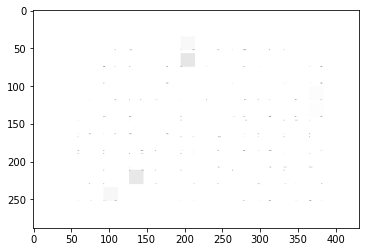

>4201, c1=-12467.889, c2=-10911.813 g=-2766.778
>4202, c1=-12399.625, c2=-10913.634 g=-5654.052
>4203, c1=-12487.471, c2=-10920.483 g=-5134.035
>4204, c1=-12497.214, c2=-10927.140 g=-4611.136
>4205, c1=-12469.846, c2=-10927.751 g=-4922.704
>4206, c1=-12528.139, c2=-10934.827 g=-4755.991
>4207, c1=-12481.474, c2=-10937.410 g=-2094.945
>4208, c1=-12481.825, c2=-10942.651 g=-4642.861
>4209, c1=-12522.885, c2=-10949.635 g=-5320.236
>4210, c1=-12518.216, c2=-10950.636 g=-4891.957
>4211, c1=-12480.576, c2=-10955.350 g=-5995.872
>4212, c1=-12515.485, c2=-10960.599 g=-5020.573
>4213, c1=-12495.537, c2=-10964.169 g=-4903.792
>4214, c1=-12543.498, c2=-10971.303 g=-5488.389
>4215, c1=-12541.179, c2=-10973.185 g=-3004.403
>4216, c1=-12527.398, c2=-10977.017 g=-5100.129
>4217, c1=-12569.371, c2=-10985.864 g=-5313.147
>4218, c1=-12567.411, c2=-10988.211 g=-4946.391
>4219, c1=-12539.134, c2=-10991.743 g=-1744.019
>4220, c1=-12568.667, c2=-10996.729 g=-3716.560
>4221, c1=-12555.999, c2=-11002.167 g=-3

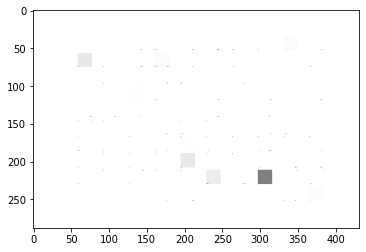

>4251, c1=-12646.784, c2=-11137.428 g=-4070.507
>4252, c1=-12727.465, c2=-11143.595 g=-4934.852
>4253, c1=-12760.179, c2=-11150.085 g=-4291.258
>4254, c1=-12717.556, c2=-11151.171 g=-6319.076
>4255, c1=-12747.217, c2=-11157.760 g=-4819.844
>4256, c1=-12782.632, c2=-11164.261 g=-4407.341
>4257, c1=-12746.432, c2=-11165.450 g=-3651.641
>4258, c1=-12743.395, c2=-11170.012 g=-5561.133
>4259, c1=-12783.886, c2=-11176.595 g=-5015.957
>4260, c1=-12756.552, c2=-11179.481 g=-4128.455
>4261, c1=-12785.054, c2=-11185.038 g=-5471.726
>4262, c1=-12774.382, c2=-11190.464 g=-5487.907
>4263, c1=-12796.672, c2=-11192.719 g=-3533.217
>4264, c1=-12799.965, c2=-11199.367 g=-5475.852
>4265, c1=-12810.265, c2=-11203.614 g=-5588.084
>4266, c1=-12802.946, c2=-11206.560 g=-2712.742
>4267, c1=-12797.680, c2=-11212.051 g=-3655.769
>4268, c1=-12844.969, c2=-11218.740 g=-3013.184
>4269, c1=-12831.814, c2=-11221.037 g=-4583.748
>4270, c1=-12844.125, c2=-11225.939 g=-4983.904
>4271, c1=-12832.572, c2=-11230.508 g=-3

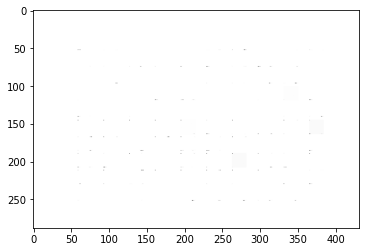

>4301, c1=-13016.420, c2=-11368.274 g=-3647.330
>4302, c1=-12985.387, c2=-11371.851 g=-6202.457
>4303, c1=-13017.389, c2=-11378.497 g=-1905.596
>4304, c1=-13020.671, c2=-11383.839 g=-2177.365
>4305, c1=-12999.579, c2=-11385.671 g=-2940.086
>4306, c1=-12976.871, c2=-11390.627 g=-4206.024
>4307, c1=-13052.206, c2=-11398.796 g=-4325.195
>4308, c1=-13025.347, c2=-11399.977 g=-3487.152
>4309, c1=-13032.618, c2=-11405.430 g=-6290.932
>4310, c1=-13033.029, c2=-11409.368 g=-2468.867
>4311, c1=-13013.844, c2=-11413.882 g=-5080.512
>4312, c1=-13078.720, c2=-11420.142 g=-4350.357
>4313, c1=-13035.653, c2=-11421.885 g=-5254.984
>4314, c1=-13067.474, c2=-11429.409 g=-4113.847
>4315, c1=-13086.563, c2=-11435.059 g=-5596.806
>4316, c1=-13072.942, c2=-11436.309 g=-2027.381
>4317, c1=-13086.670, c2=-11443.892 g=-5099.953
>4318, c1=-13086.749, c2=-11446.621 g=-6833.105
>4319, c1=-13101.756, c2=-11452.354 g=-4996.002
>4320, c1=-13109.877, c2=-11456.746 g=-4620.553
>4321, c1=-13106.517, c2=-11461.380 g=-3

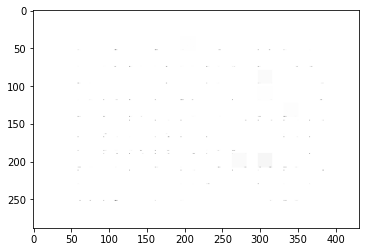

>4351, c1=-13280.165, c2=-11600.870 g=-2640.573
>4352, c1=-13262.803, c2=-11605.130 g=-3160.011
>4353, c1=-13263.429, c2=-11610.273 g=-3970.836
>4354, c1=-13287.855, c2=-11615.267 g=-4361.850
>4355, c1=-13289.338, c2=-11618.538 g=-6671.554
>4356, c1=-13247.510, c2=-11624.400 g=-4352.799
>4357, c1=-13284.203, c2=-11626.492 g=-5804.067
>4358, c1=-13279.882, c2=-11632.554 g=-6539.700
>4359, c1=-13305.691, c2=-11639.360 g=-5146.501
>4360, c1=-13326.799, c2=-11642.300 g=-4057.621
>4361, c1=-13332.020, c2=-11647.617 g=-5477.766
>4362, c1=-13325.672, c2=-11651.559 g=-4054.616
>4363, c1=-13331.782, c2=-11655.082 g=-6664.311
>4364, c1=-13324.219, c2=-11660.283 g=-6012.688
>4365, c1=-13362.738, c2=-11667.444 g=-5292.013
>4366, c1=-13382.354, c2=-11672.423 g=-4911.187
>4367, c1=-13353.564, c2=-11673.614 g=-4378.394
>4368, c1=-13323.218, c2=-11677.857 g=-6854.160
>4369, c1=-13358.926, c2=-11684.751 g=-4106.965
>4370, c1=-13357.670, c2=-11690.100 g=-6427.065
>4371, c1=-13365.298, c2=-11695.046 g=-5

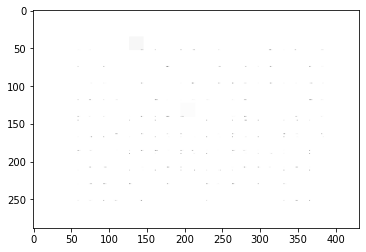

>4401, c1=-13533.121, c2=-11834.137 g=-4107.812
>4402, c1=-13566.976, c2=-11840.955 g=-1989.310
>4403, c1=-13539.347, c2=-11843.497 g=-4093.828
>4404, c1=-13566.870, c2=-11849.951 g=-4166.137
>4405, c1=-13550.132, c2=-11849.383 g=-3106.447
>4406, c1=-13505.929, c2=-11855.912 g=-3445.784
>4407, c1=-13535.152, c2=-11863.473 g=-5449.212
>4408, c1=-13580.205, c2=-11868.287 g=-5366.846
>4409, c1=-13609.363, c2=-11872.929 g=-5109.443
>4410, c1=-13591.504, c2=-11876.815 g=-3637.889
>4411, c1=-13564.277, c2=-11878.893 g=-3056.505
>4412, c1=-13573.748, c2=-11885.150 g=-5112.743
>4413, c1=-13609.876, c2=-11891.345 g=-5354.358
>4414, c1=-13616.607, c2=-11897.262 g=-2254.737
>4415, c1=-13608.732, c2=-11900.130 g=-5687.241
>4416, c1=-13624.275, c2=-11904.942 g=-3046.987
>4417, c1=-13614.927, c2=-11909.119 g=-4579.509
>4418, c1=-13637.968, c2=-11914.171 g=-4953.938
>4419, c1=-13654.683, c2=-11919.422 g=-3214.821
>4420, c1=-13602.971, c2=-11918.835 g=-5772.404
>4421, c1=-13659.868, c2=-11931.704 g=-3

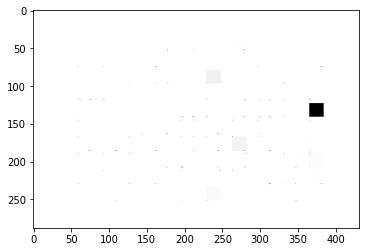

>4451, c1=-13781.899, c2=-12069.084 g=-6522.225
>4452, c1=-13837.164, c2=-12078.700 g=-4586.030
>4453, c1=-13817.833, c2=-12079.989 g=-6912.247
>4454, c1=-13834.864, c2=-12085.788 g=-5878.910
>4455, c1=-13854.148, c2=-12091.052 g=-4485.046
>4456, c1=-13829.979, c2=-12095.142 g=-4953.273
>4457, c1=-13849.282, c2=-12100.638 g=-5416.480
>4458, c1=-13833.119, c2=-12103.279 g=-4625.198
>4459, c1=-13874.955, c2=-12110.627 g=-5844.140
>4460, c1=-13822.153, c2=-12109.608 g=-3239.822
>4461, c1=-13837.951, c2=-12116.946 g=-4433.417
>4462, c1=-13888.288, c2=-12125.966 g=-3627.771
>4463, c1=-13861.738, c2=-12127.196 g=-4848.607
>4464, c1=-13836.950, c2=-12130.893 g=-4957.486
>4465, c1=-13916.064, c2=-12140.100 g=-3561.819
>4466, c1=-13868.980, c2=-12142.619 g=-2345.540
>4467, c1=-13898.223, c2=-12148.689 g=-6228.854
>4468, c1=-13905.871, c2=-12152.548 g=-4279.209
>4469, c1=-13931.641, c2=-12157.721 g=-4729.934
>4470, c1=-13924.292, c2=-12161.200 g=-4235.581
>4471, c1=-13861.333, c2=-12162.789 g=-5

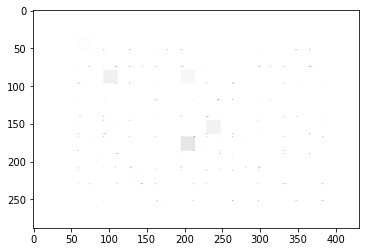

>4501, c1=-14033.738, c2=-12305.855 g=-6147.262
>4502, c1=-14099.642, c2=-12315.088 g=-5800.862
>4503, c1=-14072.829, c2=-12316.672 g=-5563.233
>4504, c1=-14054.468, c2=-12320.563 g=-4030.994
>4505, c1=-14133.727, c2=-12331.044 g=-4840.647
>4506, c1=-14120.917, c2=-12334.174 g=-5781.515
>4507, c1=-14080.657, c2=-12334.510 g=-4797.105
>4508, c1=-14149.671, c2=-12345.838 g=-5123.104
>4509, c1=-14145.249, c2=-12348.395 g=-5436.443
>4510, c1=-14142.489, c2=-12353.058 g=-4660.922
>4511, c1=-14163.377, c2=-12359.114 g=-4156.591
>4512, c1=-14120.524, c2=-12358.043 g=-3287.241
>4513, c1=-14155.252, c2=-12368.020 g=-4831.583
>4514, c1=-14137.426, c2=-12370.797 g=-4476.188
>4515, c1=-14189.379, c2=-12378.044 g=-4857.081
>4516, c1=-14180.671, c2=-12382.931 g=-5287.083
>4517, c1=-14181.738, c2=-12388.209 g=-5201.487
>4518, c1=-14176.610, c2=-12388.175 g=-5091.367
>4519, c1=-14177.080, c2=-12395.076 g=-4485.785
>4520, c1=-14206.799, c2=-12400.965 g=-5698.311
>4521, c1=-14136.278, c2=-12403.570 g=-5

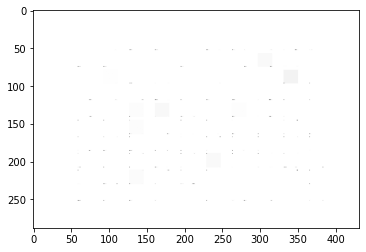

>4551, c1=-14357.572, c2=-12548.733 g=-5730.958
>4552, c1=-14373.502, c2=-12557.044 g=-3329.556
>4553, c1=-14349.749, c2=-12558.099 g=-5703.948
>4554, c1=-14378.473, c2=-12564.609 g=-4585.104
>4555, c1=-14336.040, c2=-12565.232 g=-4391.929
>4556, c1=-14409.202, c2=-12575.057 g=-2852.870
>4557, c1=-14406.897, c2=-12579.502 g=-4819.657
>4558, c1=-14406.239, c2=-12583.817 g=-4872.193
>4559, c1=-14387.034, c2=-12586.212 g=-5677.055
>4560, c1=-14420.763, c2=-12595.817 g=-6207.432
>4561, c1=-14424.379, c2=-12599.432 g=-4545.638
>4562, c1=-14383.815, c2=-12600.131 g=-4538.386
>4563, c1=-14443.915, c2=-12609.995 g=-3873.999
>4564, c1=-14430.261, c2=-12612.709 g=-6675.816
>4565, c1=-14418.121, c2=-12616.898 g=-4980.777
>4566, c1=-14392.532, c2=-12619.462 g=-4573.661
>4567, c1=-14461.928, c2=-12628.509 g=-4549.314
>4568, c1=-14470.788, c2=-12634.591 g=-2487.568
>4569, c1=-14437.924, c2=-12633.857 g=-6058.298
>4570, c1=-14486.368, c2=-12643.592 g=-5700.618
>4571, c1=-14473.558, c2=-12647.099 g=-6

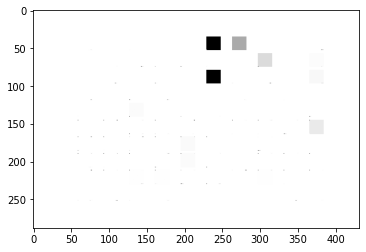

>4601, c1=-14661.043, c2=-12795.554 g=-5279.417
>4602, c1=-14561.521, c2=-12796.438 g=-3906.365
>4603, c1=-14649.331, c2=-12802.690 g=-3774.264
>4604, c1=-14670.339, c2=-12807.604 g=-5325.240
>4605, c1=-14620.853, c2=-12809.924 g=-5249.439
>4606, c1=-14698.652, c2=-12819.343 g=-5942.344
>4607, c1=-14682.884, c2=-12822.192 g=-6693.703
>4608, c1=-14648.284, c2=-12825.472 g=-3346.286
>4609, c1=-14674.922, c2=-12832.658 g=-4743.777
>4610, c1=-14664.891, c2=-12832.942 g=-6151.464
>4611, c1=-14659.230, c2=-12839.216 g=-5420.264
>4612, c1=-14696.848, c2=-12848.309 g=-6314.725
>4613, c1=-14652.278, c2=-12847.102 g=-6037.782
>4614, c1=-14739.844, c2=-12857.921 g=-4229.483
>4615, c1=-14711.196, c2=-12860.162 g=-4975.030
>4616, c1=-14706.832, c2=-12865.540 g=-3568.497
>4617, c1=-14728.240, c2=-12869.184 g=-5600.825
>4618, c1=-14734.674, c2=-12876.079 g=-5940.736
>4619, c1=-14738.279, c2=-12879.955 g=-4393.101
>4620, c1=-14736.114, c2=-12883.762 g=-6673.117
>4621, c1=-14757.055, c2=-12891.744 g=-5

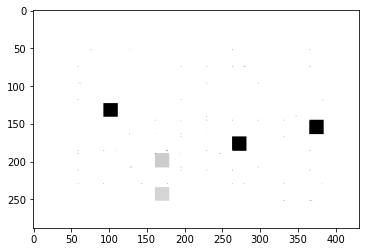

>4651, c1=-14932.881, c2=-13037.370 g=-4040.354
>4652, c1=-14895.728, c2=-13042.931 g=-6052.902
>4653, c1=-14941.718, c2=-13049.814 g=-4326.475
>4654, c1=-14930.957, c2=-13052.383 g=-3387.290
>4655, c1=-14933.742, c2=-13058.047 g=-5161.017
>4656, c1=-14940.966, c2=-13062.914 g=-8333.215
>4657, c1=-14898.328, c2=-13065.362 g=-6006.823
>4658, c1=-14971.700, c2=-13073.587 g=-3640.737
>4659, c1=-14968.155, c2=-13076.566 g=-3191.234
>4660, c1=-14953.539, c2=-13080.955 g=-5886.434
>4661, c1=-14989.348, c2=-13088.297 g=-4904.142
>4662, c1=-14986.237, c2=-13092.005 g=-4212.972
>4663, c1=-15000.121, c2=-13098.211 g=-7015.311
>4664, c1=-14983.304, c2=-13102.620 g=-5404.837
>4665, c1=-14972.931, c2=-13104.148 g=-6582.211
>4666, c1=-14977.720, c2=-13111.036 g=-5838.646
>4667, c1=-15009.240, c2=-13116.498 g=-5898.012
>4668, c1=-15023.125, c2=-13121.339 g=-5651.621
>4669, c1=-15029.395, c2=-13127.659 g=-5929.740
>4670, c1=-15048.206, c2=-13133.458 g=-6024.134
>4671, c1=-15040.327, c2=-13137.542 g=-5

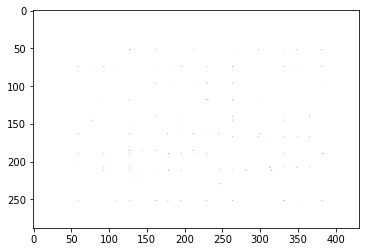

>4701, c1=-15240.354, c2=-13289.943 g=-5009.454
>4702, c1=-15221.171, c2=-13290.096 g=-5415.633
>4703, c1=-15191.755, c2=-13294.214 g=-5415.758
>4704, c1=-15221.154, c2=-13300.154 g=-5869.191
>4705, c1=-15252.054, c2=-13308.108 g=-4560.112
>4706, c1=-15207.244, c2=-13309.684 g=-7023.492
>4707, c1=-15235.362, c2=-13314.978 g=-4211.859
>4708, c1=-15226.717, c2=-13319.363 g=-6118.823
>4709, c1=-15270.322, c2=-13328.506 g=-4497.993
>4710, c1=-15248.178, c2=-13329.442 g=-5230.527
>4711, c1=-15275.186, c2=-13336.897 g=-4169.968
>4712, c1=-15242.494, c2=-13337.791 g=-4266.807
>4713, c1=-15248.077, c2=-13342.736 g=-6860.062
>4714, c1=-15299.532, c2=-13352.397 g=-5740.373
>4715, c1=-15282.563, c2=-13357.177 g=-2483.104
>4716, c1=-15262.505, c2=-13358.988 g=-5690.152
>4717, c1=-15326.426, c2=-13368.052 g=-6345.848
>4718, c1=-15273.578, c2=-13367.354 g=-4763.929
>4719, c1=-15312.484, c2=-13375.968 g=-5531.764
>4720, c1=-15345.602, c2=-13384.675 g=-3306.295
>4721, c1=-15286.263, c2=-13382.860 g=-3

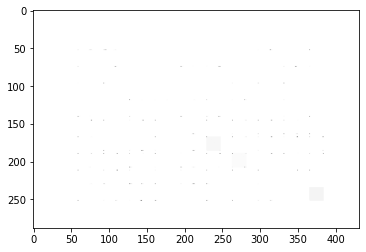

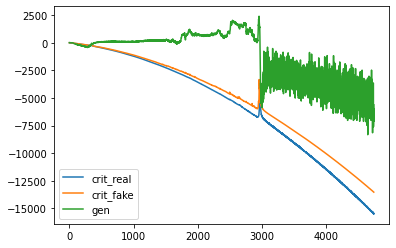

In [ ]:
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

In [ ]:
!zip -r /content/file.zip /content  ## download results from a zip file in Colab

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.04.21/ (stored 0%)
  adding: content/.config/logs/2021.04.21/13.38.56.174593.log (deflated 53%)
  adding: content/.config/logs/2021.04.21/13.38.18.505216.log (deflated 54%)
  adding: content/.config/logs/2021.04.21/13.38.33.645732.log (deflated 87%)
  adding: content/.config/logs/2021.04.21/13.37.59.675948.log (deflated 91%)
  adding: content/.config/logs/2021.04.21/13.38.55.616588.log (deflated 55%)
  adding: content/.config/logs/2021.04.21/13.38.39.238346.log (deflated 54%)
  adding: content/.config/active_config (stored 0%)
  adding: 

# Working

In [1]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

11493376/11490434 [==============================] - 0s 0us/step
(6265, 28, 28, 1)
>1, c1=-2.270, c2=0.017 g=0.113
>2, c1=-6.854, c2=0.095 g=-0.938
>3, c1=-10.175, c2=0.148 g=-1.763
>4, c1=-12.266, c2=0.203 g=-2.425
>5, c1=-14.395, c2=0.275 g=-3.381
>6, c1=-16.327, c2=0.323 g=-3.904
>7, c1=-17.539, c2=0.377 g=-4.664
>8, c1=-18.927, c2=0.457 g=-5.455
>9, c1=-19.893, c2=0.528 g=-6.480
>10, c1=-20.975, c2=0.598 g=-8.021
>11, c1=-22.193, c2=0.677 g=-8.797
>12, c1=-23.133, c2=0.751 g=-9.832
>13, c1=-24.404, c2=0.848 g=-10.791
>14, c1=-25.380, c2=0.927 g=-11.861
>15, c1=-25.655, c2=1.023 g=-12.818
>16, c1=-25.833, c2=1.106 g=-14.046
>17, c1=-26.503, c2=1.204 g=-14.906
>18, c1=-28.171, c2=1.272 g=-15.283
>19, c1=-28.580, c2=1.353 g=-16.292
>20, c1=-28.986, c2=1.409 g=-16.677
>21, c1=-29.399, c2=1.450 g=-17.336
>22, c1=-30.472, c2=1.509 g=-17.850
>23, c1=-30.706, c2=1.572 g=-18.894
>24, c1=-31.308, c2=1.641 g=-19.177
>25, c1=-31.787, c2=1.647 g=-19.711
>26, c1=-32.516, c2=1.648 g=-20.126
>27, 